In [38]:
import numpy as np
import pandas as pd
from typing import Dict, List, Tuple
from tqdm import tqdm
tqdm.pandas()

import umap.umap_ as umap
import umap.plot
import umap.aligned_umap
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

from rdkit.Chem import AllChem
from rdkit import Chem
from rdkit.Chem.rdMolDescriptors import GetMACCSKeysFingerprint

from padelpy import from_smiles
import torch
import yaml
from argparse import Namespace
from fast_transformers.masking import LengthMask as LM
import sys
import os

notebook_directory = os.getcwd()
molformer_directory = os.path.join(notebook_directory, "..")
sys.path.append(molformer_directory)
from MolFormer.finetune.tokenizer.tokenizer import MolTranBertTokenizer
from MolFormer.training.train_pubchem_light import LightningModule

In [ ]:

def create_manifold(
    df: pd.DataFrame, 
    n_components: int,
    n_neighbors: int, 
    min_dist: float,
    metric: str,
    random_state: int,
    target_weight: float,
    supervised: bool,
) -> Tuple[umap.umap_.UMAP, np.ndarray]:
    x, y, y_str = df.drop(["label", "label_str"], axis=1), df[["label"]].values.flatten(), df[["label_str"]].values.flatten()
    y_encoded = pd.factorize(y)[0]
    if supervised:
        manifold = umap.UMAP(
            n_components=n_components, 
            n_neighbors=n_neighbors, 
            min_dist=min_dist, 
            metric=metric, 
            random_state=random_state, 
            n_jobs=1,
            target_weight=target_weight,
        ).fit(x, y_encoded)
    else: 
        manifold = umap.UMAP(
            n_components=n_components, 
            n_neighbors=n_neighbors, 
            min_dist=min_dist, 
            metric=metric, 
            random_state=random_state, 
            n_jobs=1,
        ).fit(x)
    return manifold, y_str

def load_checkpoint():
    with open("MoLFormer/data/Pretrained MoLFormer/hparams.yaml", "r") as f:
        config = Namespace(**yaml.safe_load(f))
    tokenizer = MolTranBertTokenizer("MoLFormer/training/bert_vocab.txt")
    ckpt = "MoLFormer/data/Pretrained MoLFormer/checkpoints/N-Step-Checkpoint_3_30000.ckpt"
    lm = LightningModule(config, tokenizer.vocab).load_from_checkpoint(ckpt, config=config, vocab=tokenizer.vocab)
    return tokenizer, lm

def batch_split(data, batch_size=64):
    i = 0
    while i < len(data):
        yield data[i : min(i + batch_size, len(data))]
        i += batch_size

def get_embeddings(model, smiles, tokenizer, batch_size=64):
    model.eval()
    embeddings = []
    with tqdm(total=len(smiles), desc="Getting embeddings from MolFormer", ncols=100) as pbar:
        for batch in batch_split(smiles, batch_size=batch_size):
            batch_enc = tokenizer.batch_encode_plus(batch, padding=True, add_special_tokens=True)
            idx, mask = torch.tensor(batch_enc["input_ids"]), torch.tensor(batch_enc["attention_mask"])
            with torch.no_grad():
                token_embeddings = model.blocks(model.tok_emb(idx), length_mask=LM(mask.sum(-1)))
            # average pooling over tokens
            input_mask_expanded = mask.unsqueeze(-1).expand(token_embeddings.size()).float()
            sum_embeddings = torch.sum(token_embeddings * input_mask_expanded, 1)
            sum_mask = torch.clamp(input_mask_expanded.sum(1), min=1e-9)
            embedding = sum_embeddings / sum_mask
            embeddings.append(embedding.detach().cpu())
            pbar.update(len(batch))
    return torch.cat(embeddings)

def create_features_molformer(df: pd.DataFrame, tokenizer, lm) -> pd.DataFrame:
    def canonicalize(s):
        return Chem.MolToSmiles(Chem.MolFromSmiles(s), canonical=True, isomericSmiles=False)
    smiles = df.smiles.apply(canonicalize)
    embeddings = get_embeddings(lm, smiles, tokenizer).numpy()
    df = df.copy()
    df["fingerprint"] = [embedding.tolist() for embedding in embeddings]
    return df

def convert_to_maccs_fingerprints(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    mols = [AllChem.MolFromSmiles(smiles) for smiles in df["smiles"]]
    fp_vecs = [GetMACCSKeysFingerprint(mol) for mol in mols]
    fp_arrays = [np.frombuffer(fp_vec.ToBitString().encode(), 'u1') - ord('0') for fp_vec in fp_vecs]
    df["fingerprint"] = [fp_array.tolist() for fp_array in fp_arrays]
    return df

def convert_to_morgan_fingerprints(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    mols = [AllChem.MolFromSmiles(smiles) for smiles in df["smiles"]]
    fp_vecs = [AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=1024) for mol in mols]
    fp_arrays = [np.frombuffer(fp_vec.ToBitString().encode(), 'u1') - ord('0') for fp_vec in fp_vecs]
    df["fingerprint"] = [fp_array.tolist() for fp_array in fp_arrays]
    return df

def convert_to_rdk_fingerprints(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    mols = [AllChem.MolFromSmiles(smiles) for smiles in df["smiles"]]
    fp_vecs = [Chem.RDKFingerprint(mol) for mol in mols]
    fp_arrays = [np.frombuffer(fp_vec.ToBitString().encode(), 'u1') - ord('0') for fp_vec in fp_vecs]
    df["fingerprint"] = [fp_array.tolist() for fp_array in fp_arrays]
    return df


def create_dfs_from_final_and_removed(df: pd.DataFrame, df_removed: pd.DataFrame, final: bool, feature_type: str) -> Tuple[
    pd.DataFrame, 
    pd.DataFrame, 
    pd.DataFrame, 
    pd.DataFrame, 
    pd.DataFrame, 
    pd.DataFrame, 
]:
    if feature_type == "MACCS":
        size = 167
        df = convert_to_maccs_fingerprints(df=df)
        df_removed = convert_to_maccs_fingerprints(df=df_removed)
    elif feature_type == "Morgan":
        size = 1024
        df = convert_to_morgan_fingerprints(df=df)
        df_removed = convert_to_morgan_fingerprints(df=df_removed)
    elif feature_type == "RDK":
        size = 2048
        df = convert_to_rdk_fingerprints(df=df)
        df_removed = convert_to_rdk_fingerprints(df=df_removed)
    elif feature_type == "Molformer":
        size = 768
        tokenizer, lm = load_checkpoint()
        df = create_features_molformer(df=df, tokenizer=tokenizer, lm=lm)
        df_removed = create_features_molformer(df=df_removed, tokenizer=tokenizer, lm=lm)
    
    if final: 
        curated = "$Curated_{Final}$"
        removed = "$Curated_{Removed}$"
    else: 
        curated = "$Curated_{BIOWIN}$"
        removed = "$Curated_{Problematic}$"
    
    cols = [*range(0, size, 1)]
    df_fp = pd.DataFrame(df.fingerprint.tolist(), columns=cols)
    df_removed_fp = pd.DataFrame(df_removed.fingerprint.tolist(), columns=cols)
    
    df_fp["label"] = curated
    df_removed_fp["label"] = removed
    df_removed_labels = pd.concat([df_fp, df_removed_fp], axis=0)
    df_removed_labels["label_str"] = df_removed_labels['label']

    df_fp["label"] = df["label"]
    df_removed_fp["label"] = df_removed['label']
    df_all = pd.concat([df_fp, df_removed_fp], axis=0)
    df_all["label_str"] = df_all['label'].map({0: f"{curated} NRB", 1: f"{curated} RB"})

    df_fp["label"] = df["label"]
    df_removed_fp["label"] = df_removed['label'] + 2
    df_four_labels = pd.concat([df_fp, df_removed_fp], axis=0)
    df_four_labels["label_str"] = df_four_labels['label'].map({0: f"{curated} NRB", 1: f"{curated} RB", 2: f"{removed} NRB", 3: f"{removed} RB"})

    df_removed_fp["label"] = df_removed['label']
    df_four_colors = pd.concat([df_fp, df_removed_fp], axis=0)
    df_four_colors["label_str"] = df_four_labels['label_str']

    df_fp_labeled = pd.DataFrame(df.fingerprint.tolist(), columns=cols)
    df_fp_labeled["label"] = df["label"]
    df_fp_labeled["label_str"] = df_fp_labeled['label'].map({0: f"{curated} NRB", 1: f"{curated} RB"})

    # semisupervised
    df_removed_fp["label"] = -1
    df_semi_supervised = pd.concat([df_fp, df_removed_fp], axis=0)
    df_semi_supervised["label_str"] = df_four_labels['label_str']

    return df_removed_labels, df_all, df_four_labels, df_four_colors, df_fp_labeled, df_semi_supervised
    

def create_dfs_biowin_umap(feature_type: str) -> Tuple[
    pd.DataFrame, 
    pd.DataFrame, 
    pd.DataFrame, 
    pd.DataFrame, 
    pd.DataFrame, 
    pd.DataFrame, 
]:
    df_biowin = pd.read_csv("datasets/curated_data/class_curated_biowin.csv", index_col=0)
    df_biowin = df_biowin[['cas', 'smiles','inchi_from_smiles', 'label', 'linear_label',
        'non_linear_label', 'miti_linear_label', 'miti_non_linear_label']]
    df_biowin.reset_index(inplace=True, drop=True)
    df_problematic = pd.read_csv("datasets/curated_data/class_curated_biowin_problematic.csv", index_col=0)
    df_problematic.reset_index(inplace=True, drop=True)
    return create_dfs_from_final_and_removed(df=df_biowin, df_removed=df_problematic, final=False, feature_type=feature_type)


def create_dfs_final_umap(feature_type: str) -> Tuple[
    pd.DataFrame, 
    pd.DataFrame, 
    pd.DataFrame, 
    pd.DataFrame, 
    pd.DataFrame, 
    pd.DataFrame, 
]:
    df_final = pd.read_csv("datasets/curated_data/class_curated_final.csv", index_col=0)
    df_final = df_final[['cas', 'smiles','inchi_from_smiles', 'label', 'linear_label',
        'non_linear_label', 'miti_linear_label', 'miti_non_linear_label']]
    df_final.reset_index(inplace=True, drop=True)
    df_removed = pd.read_csv("datasets/curated_data/class_curated_final_removed.csv", index_col=0)
    df_removed["label"] = df_removed["y_true"]
    df_removed.reset_index(inplace=True, drop=True)
    return create_dfs_from_final_and_removed(df=df_final, df_removed=df_removed, final=True, feature_type=feature_type)


def create_plot(
    manifolds: List[umap.umap_.UMAP], 
    y_strs: List[np.ndarray], 
    titles: List[str], 
    legend_loc: List[str], 
    number_of_labels: List[int],
    figure_title: str,
    final: List[bool],
) -> None:

    _, axs = plt.subplots(2, 3, figsize=(30, 20))

    for i, ax in enumerate(axs.flatten()):
        label=y_strs[i]
        final_cur = final[i]

        if final_cur: 
            curated = "$Curated_{Final}$"
            removed = "$Curated_{Removed}$"
        else: 
            curated = "$Curated_{BIOWIN}$"
            removed = "$Curated_{Problematic}$"
    
        if ('NRB' in label[0]) | ('RB' in label[0]):
            color_key={
                f"{curated} NRB": 'royalblue', 
                f"{removed} NRB": 'limegreen', 
                f"{curated} RB": 'darkorange', 
                f"{removed} RB": 'fuchsia'} 
        else: 
            if final_cur:
                color_key={
                    curated: 'green', 
                    removed: 'gold'}
            else: 
                color_key={
                    curated: 'forestgreen', 
                    removed: 'yellow'}
        
        umap.plot.points(
            umap_object=manifolds[i], 
            labels=label, 
            color_key=color_key,
            background='black',
            ax=ax,
        ) 
        ax.set_xlabel(titles[i], fontsize=22)
        nrb = mpatches.Patch(color='royalblue', label=f"{curated} NRB")
        rb = mpatches.Patch(color='darkorange', label=f"{curated} RB")
        if number_of_labels[i] == 4:
            nrb_r = mpatches.Patch(color='limegreen', label=f"{removed} NRB")
            rb_r = mpatches.Patch(color='fuchsia', label=f"{removed} RB")
            ax.legend(loc=legend_loc[i], handles=[nrb, rb, nrb_r, rb_r], fontsize=16)
        elif ('NRB' not in label[0]) & ('RB' not in label[0]):
            if final_cur:
                cb = mpatches.Patch(color='green', label=curated)
                cr = mpatches.Patch(color='gold', label=removed)
            else: 
                cb = mpatches.Patch(color='forestgreen', label=curated)
                cr = mpatches.Patch(color='yellow', label=removed)
            ax.legend(loc=legend_loc[i], handles=[cb, cr], fontsize=16)
        else:
            ax.legend(loc=legend_loc[i], handles=[nrb, rb], fontsize=16)
        umap.plot.plt.savefig(f'figures/{figure_title}.png')


In [3]:
def create_plot_umap_semisupervised(
    n_components, 
    n_neighbors, 
    min_dist, 
    target_weight, 
    metric, 
    random_state,
    feature_type,
    legend_loc,
) -> None:

    # Biowin
    df_removed_labels_biowin, _, df_four_labels_biowin, _, _, df_semi_supervised_biowin = create_dfs_biowin_umap(feature_type=feature_type)

    manifold_unsupervised_removed, y_unsupervised_str_removed = create_manifold(
        df=df_removed_labels_biowin, 
        n_components=n_components,
        n_neighbors=n_neighbors, 
        min_dist=min_dist,
        metric=metric,
        random_state=random_state,
        target_weight=target_weight,
        supervised=False,
    )
    manifold_unsupervised, y_unsupervised_str = create_manifold(
        df=df_four_labels_biowin, 
        n_components=n_components,
        n_neighbors=n_neighbors, 
        min_dist=min_dist,
        metric=metric,
        random_state=random_state,
        target_weight=target_weight,
        supervised=False,
    )
    manifold_semi_supervised, y_semi_supervised_str = create_manifold(
        df=df_semi_supervised_biowin, 
        n_components=n_components,
        n_neighbors=n_neighbors, 
        min_dist=min_dist,
        metric=metric,
        random_state=random_state,
        target_weight=target_weight,
        supervised=True,
    )

    # Final
    df_removed_labels_final, _, df_four_labels_final, _, _, df_semi_supervised_final = create_dfs_final_umap(feature_type=feature_type)

    manifold_unsupervised_removed_final, y_unsupervised_str_removed_final = create_manifold(
        df=df_removed_labels_final, 
        n_components=n_components,
        n_neighbors=n_neighbors, 
        min_dist=min_dist,
        metric=metric,
        random_state=random_state,
        target_weight=target_weight,
        supervised=False,
    )
    manifold_unsupervised_final, y_unsupervised_str_final = create_manifold(
        df=df_four_labels_final, 
        n_components=n_components,
        n_neighbors=n_neighbors, 
        min_dist=min_dist,
        metric=metric,
        random_state=random_state,
        target_weight=target_weight,
        supervised=False,
    )
    manifold_semi_supervised_final, y_semi_supervised_str_final = create_manifold(
        df=df_semi_supervised_final, 
        n_components=n_components,
        n_neighbors=n_neighbors, 
        min_dist=min_dist,
        metric=metric,
        random_state=random_state,
        target_weight=target_weight,
        supervised=True,
    )

    # Create plot
    manifolds = [
        manifold_unsupervised_removed,
        manifold_unsupervised,
        manifold_semi_supervised, 
        manifold_unsupervised_removed_final,
        manifold_unsupervised_final,
        manifold_semi_supervised_final 
    ]
    y_strs = [
        y_unsupervised_str_removed,
        y_unsupervised_str,
        y_semi_supervised_str,
        y_unsupervised_str_removed_final,
        y_unsupervised_str_final,
        y_semi_supervised_str_final,
    ]

    titles = [
        'a) $Curated_{BIOWIN}$ + $Curated_{Problematic}$ \n unsupervised',
        'b) $Curated_{BIOWIN}$ + $Curated_{Problematic}$ \n unsupervised with labels',
        'c) $Curated_{BIOWIN}$ + $Curated_{Problematic}$ \n semi-supervised' + f'(target_weight={target_weight})',
        'd) $Curated_{Final}$ + $Curated_{Removed}$ \n unsupervised',
        'e) $Curated_{Final}$ + $Curated_{Removed}$ \n  unsupervised with labels',
        'f) $Curated_{Final}$ + $Curated_{Removed}$ \n  semi-supervised ' + f'(target_weight={target_weight})',
    ]
    number_of_labels = [2, 4, 4, 2, 4, 4]

    create_plot(
        manifolds=manifolds, 
        y_strs=y_strs, 
        titles=titles, 
        legend_loc=legend_loc, 
        number_of_labels=number_of_labels,
        figure_title=f"umap_semisupervised_{feature_type}",
        final=[False, False, False, True, True, True]
    )

In [ ]:
create_plot_umap_semisupervised(
    n_components=2, 
    n_neighbors=15, 
    min_dist=0.5, 
    target_weight=0.1, 
    metric="manhattan", 
    random_state=42,
    feature_type="MACCS",
    legend_loc=[
        'upper left',
        'upper left',
        'upper right',
        'upper left',
        'upper left',
        'upper left',
    ],
)

In [ ]:
create_plot_umap_semisupervised(
    n_components=2, 
    n_neighbors=15, 
    min_dist=0.5, 
    target_weight=0.1, 
    metric="manhattan", 
    random_state=42,
    feature_type="RDK",
    legend_loc=[
        'upper left',
        'upper left',
        'upper right',
        'upper left',
        'upper left',
        'upper left',
    ],
)

In [ ]:
create_plot_umap_semisupervised(
    n_components=2, 
    n_neighbors=15, 
    min_dist=0.5, 
    target_weight=0.1, 
    metric="manhattan", 
    random_state=42,
    feature_type="Morgan",
    legend_loc=[
        'upper left',
        'upper left',
        'upper right',
        'upper left',
        'upper left',
        'upper left',
    ],
)

Using Rotation Embedding
Using Rotation Embedding
Using Rotation Embedding
Using Rotation Embedding
Using Rotation Embedding
Using Rotation Embedding
Using Rotation Embedding
Using Rotation Embedding
Using Rotation Embedding
Using Rotation Embedding
Using Rotation Embedding
Using Rotation Embedding


Global seed set to 12345


Using Rotation Embedding
Using Rotation Embedding
Using Rotation Embedding
Using Rotation Embedding
Using Rotation Embedding
Using Rotation Embedding
Using Rotation Embedding
Using Rotation Embedding
Using Rotation Embedding
Using Rotation Embedding
Using Rotation Embedding
Using Rotation Embedding


Global seed set to 12345
Getting embeddings from MolFormer:   0%|                                   | 0/3749 [00:00<?, ?it/s]/Users/paulina_koerner/Desktop/MasterThesis/molformer_venv/lib/python3.11/site-packages/fast_transformers/feature_maps/fourier_features.py:37: UserWarning: torch.qr is deprecated in favor of torch.linalg.qr and will be removed in a future PyTorch release.
The boolean parameter 'some' has been replaced with a string parameter 'mode'.
Q, R = torch.qr(A, some)
should be replaced with
Q, R = torch.linalg.qr(A, 'reduced' if some else 'complete') (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/BatchLinearAlgebra.cpp:2432.)
  Q, _ = torch.qr(block)
Getting embeddings from MolFormer: 100%|████████████████████████| 1296/1296 [04:51<00:00,  4.45it/s]


Using Rotation Embedding
Using Rotation Embedding
Using Rotation Embedding
Using Rotation Embedding
Using Rotation Embedding
Using Rotation Embedding
Using Rotation Embedding
Using Rotation Embedding
Using Rotation Embedding
Using Rotation Embedding
Using Rotation Embedding
Using Rotation Embedding


Global seed set to 12345


Using Rotation Embedding
Using Rotation Embedding
Using Rotation Embedding
Using Rotation Embedding
Using Rotation Embedding
Using Rotation Embedding
Using Rotation Embedding
Using Rotation Embedding
Using Rotation Embedding
Using Rotation Embedding
Using Rotation Embedding
Using Rotation Embedding


Global seed set to 12345
Getting embeddings from MolFormer: 100%|████████████████████████| 1294/1294 [04:31<00:00,  4.77it/s]


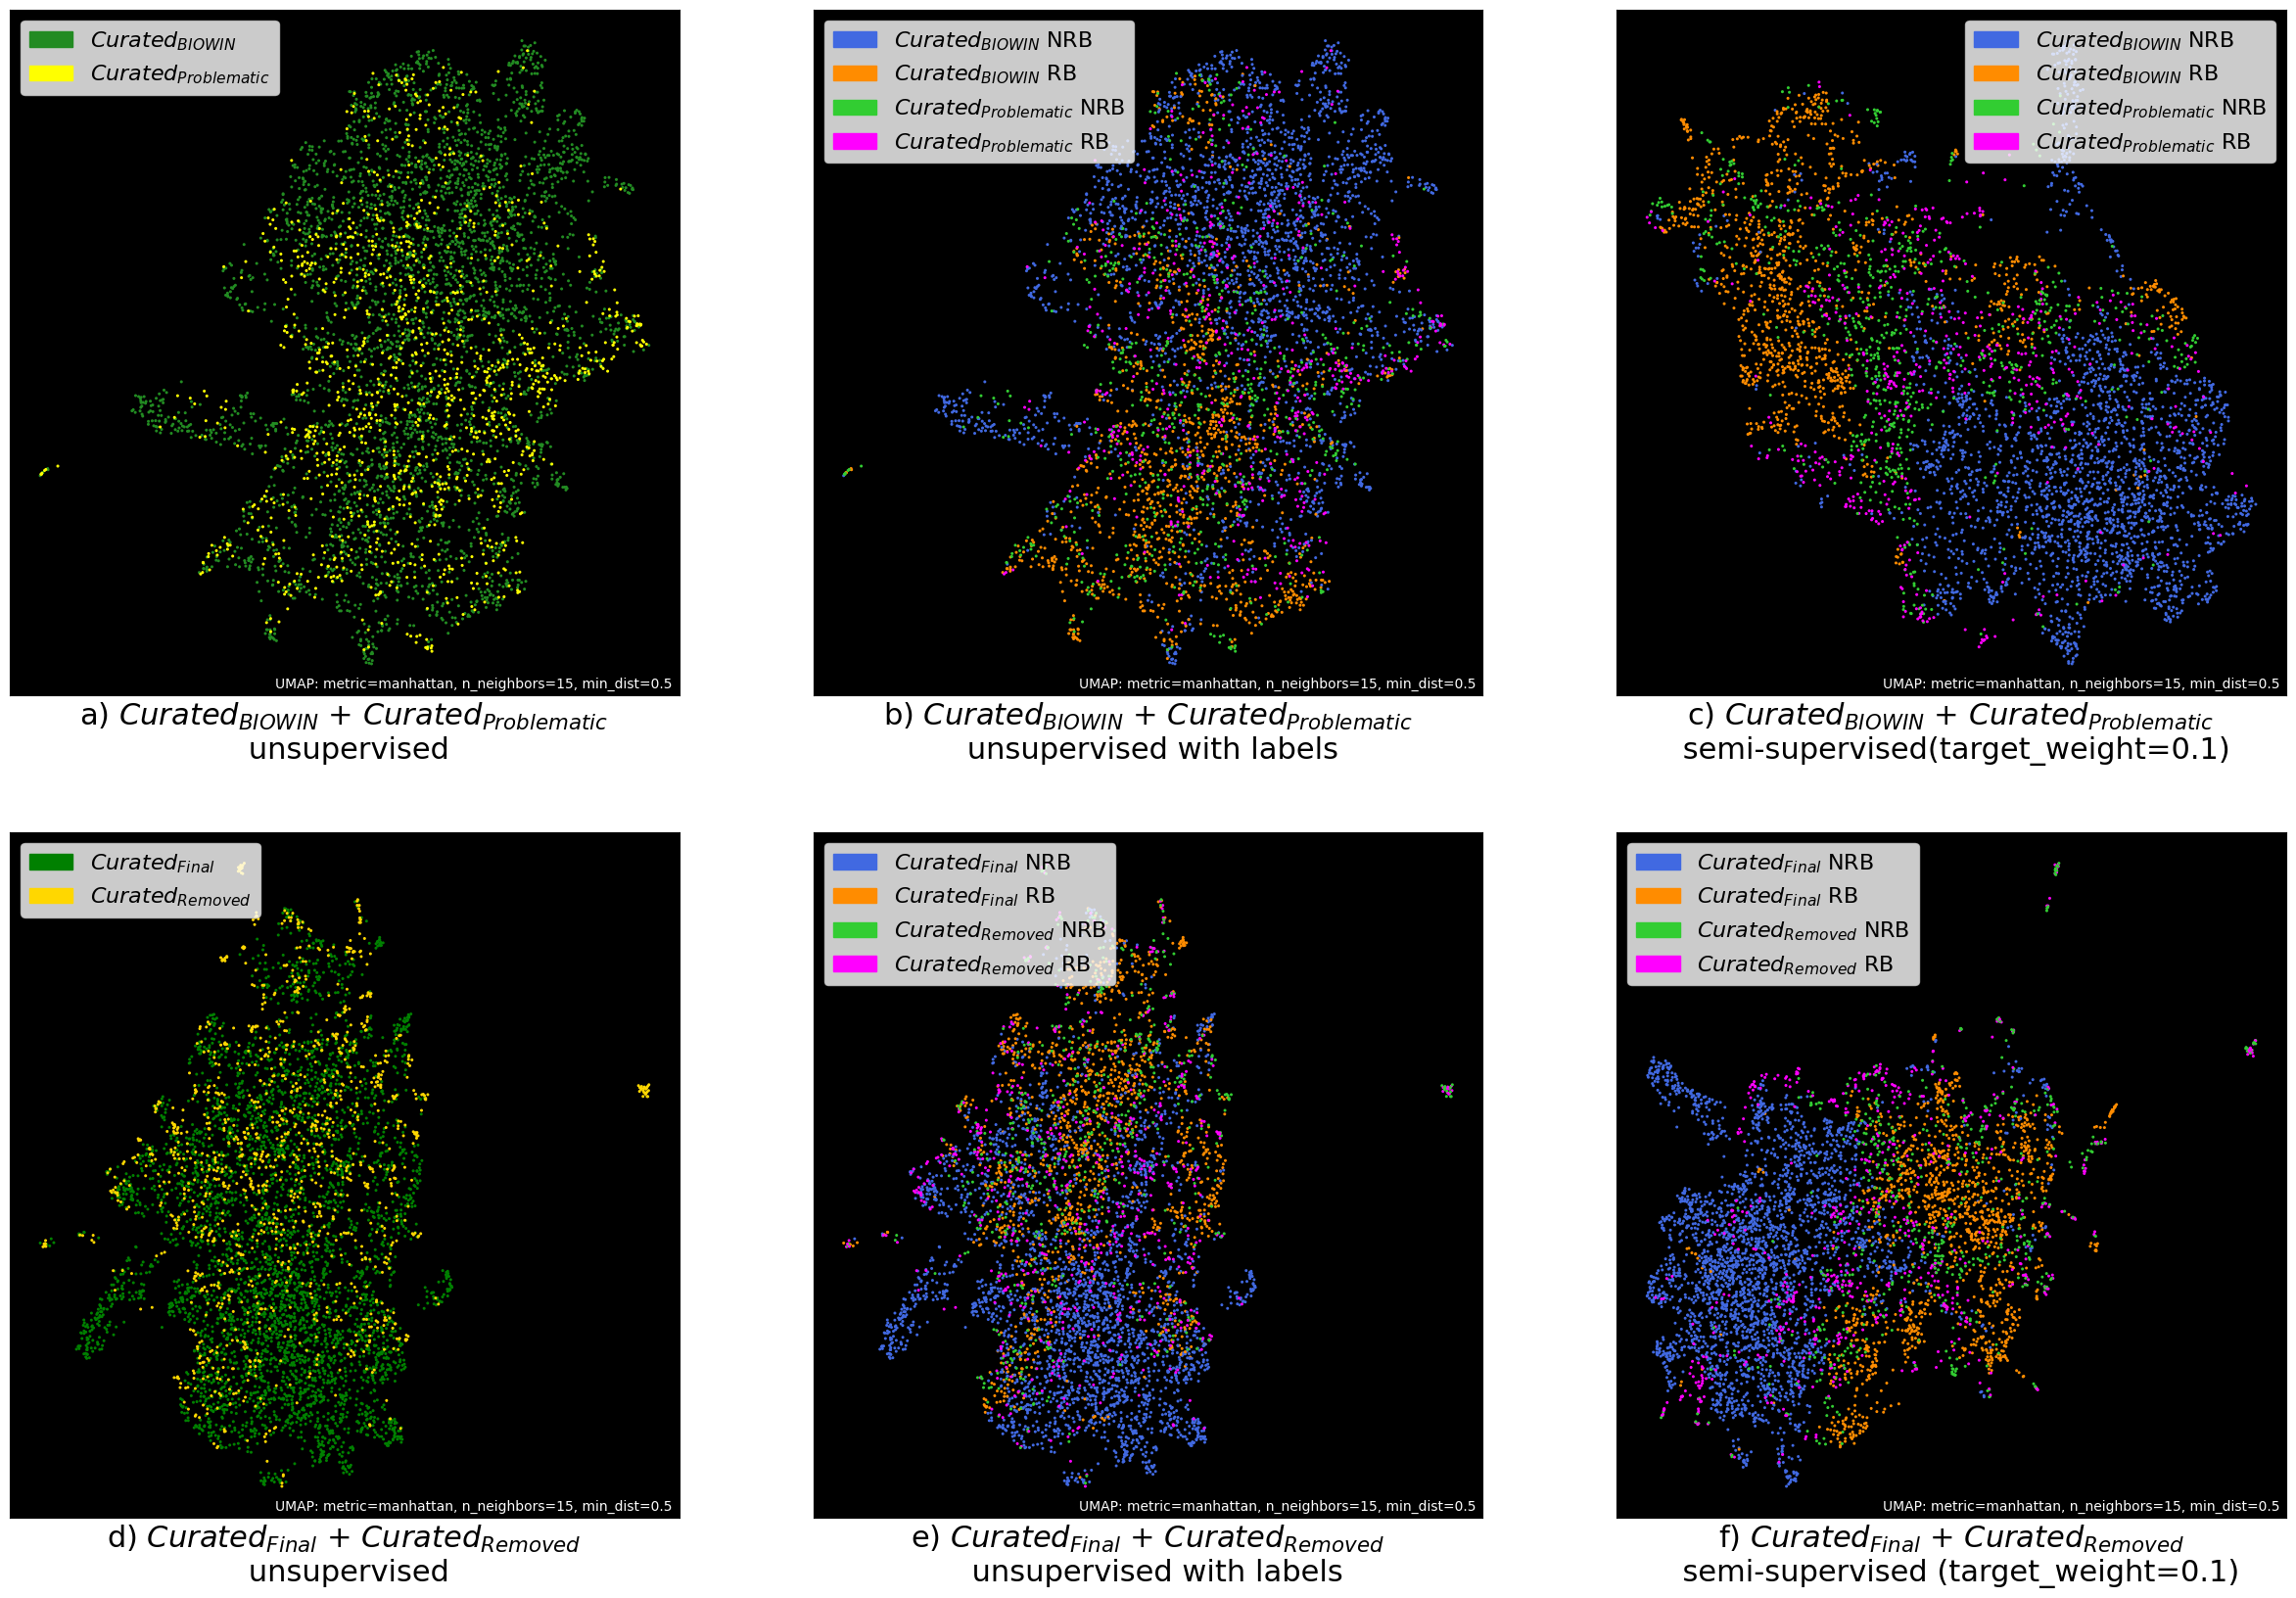

In [12]:
create_plot_umap_semisupervised(
    n_components=2, 
    n_neighbors=15, 
    min_dist=0.5, 
    target_weight=0.1, 
    metric="manhattan", 
    random_state=42,
    feature_type="Molformer",
    legend_loc=[
        'upper left',
        'upper left',
        'upper right',
        'upper left',
        'upper left',
        'upper left',
    ],
)

# Create TOC

In [18]:
_, _, df_four_labels, _, _, df_semi_supervised_final = create_dfs_final_umap(feature_type="MACCS")

manifold_3D, y_3D = create_manifold(
    df=df_semi_supervised_final, 
    n_components=2,
    n_neighbors=15, 
    min_dist=0.5,
    metric="manhattan",
    random_state=42,
    target_weight=0.1,
    supervised=True,
)

In [35]:
import plotly.express as px

df_semi_supervised_final.reset_index(inplace=True, drop=True)
x, y, y_str = df_semi_supervised_final.drop(["label", "label_str"], axis=1), df_semi_supervised_final[["label"]].values.flatten(), df_semi_supervised_final[["label_str"]].values.flatten()
y_encoded = pd.factorize(y)[0]

embedding = umap.UMAP(
    n_neighbors=15,
    min_dist=0.3,
    metric='manhattan',
    n_components=3,
    random_state=42,
    target_weight=0.3,
).fit(x, y_encoded)

df = pd.DataFrame(embedding.transform(x), columns=['x', 'y', 'z'])
df['label_str'] = df_semi_supervised_final['label_str']

curated = "$Curated_{Final}$"
removed = "$Curated_{Removed}$"

color_key={
    f"{curated} NRB": 'royalblue', 
    f"{removed} NRB": 'forestgreen', 
    f"{curated} RB": 'orange', 
    f"{removed} RB": 'fuchsia'} 

fig = px.scatter_3d(
        df, 
        x='x', 
        y='y', 
        z='z',
        color='label_str',
        template='plotly_white', # plotly_dark, plotly_white
        color_discrete_map=color_key,
        width=1000,
        height=1000,
)
fig.update_layout() # margin=dict(l=0, r=0, b=0, t=0)
fig.update_traces(marker_size=2)

/Users/paulina_koerner/Desktop/MasterThesis/molformer_venv/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning:

n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.



<Axes: >

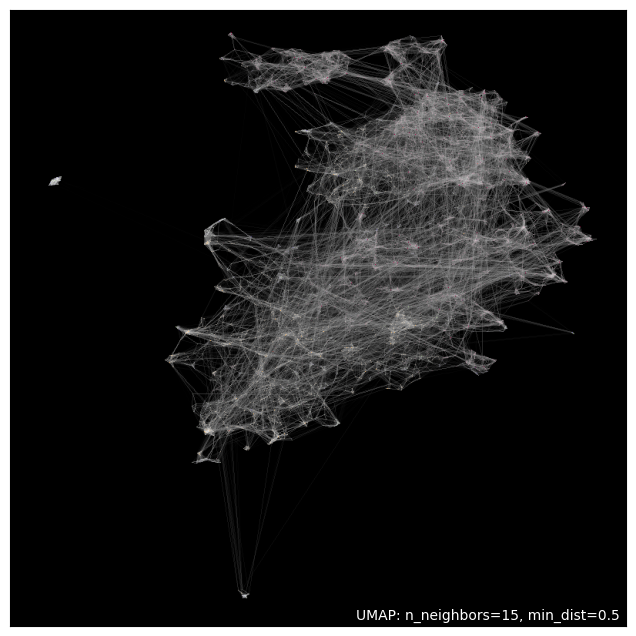

In [36]:
umap.plot.connectivity(manifold_3D, labels=y_3D, show_points=True, theme="viridis")

/Users/paulina_koerner/Desktop/MasterThesis/molformer_venv/lib/python3.11/site-packages/umap/plot.py:894: UserWarning:

Hammer edge bundling is expensive for large graphs!
This may take a long time to compute!



<Axes: >

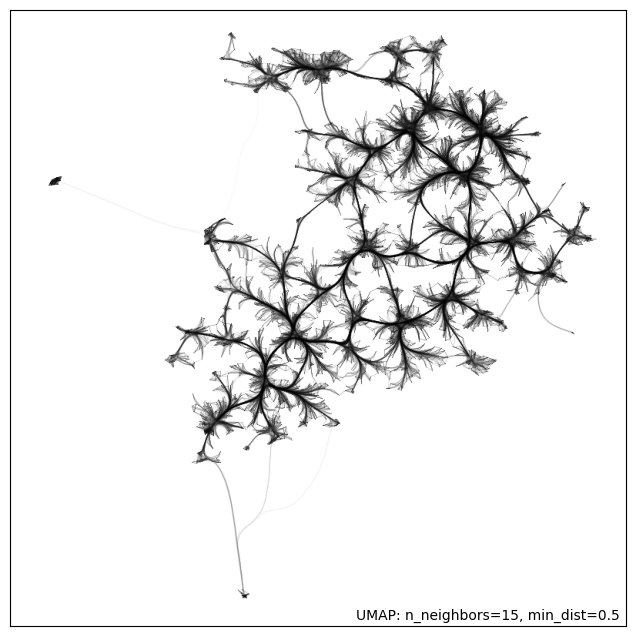

In [37]:
umap.plot.connectivity(manifold_3D, edge_bundling='hammer')

## Other fingerprints

In [28]:

def create_manifold(
    df: pd.DataFrame, 
    n_components: int,
    n_neighbors: int, 
    min_dist: float,
    metric: str,
    random_state: int,
    target_weight: float,
    supervised: bool,
) -> Tuple[umap.umap_.UMAP, np.ndarray]:
    x, y, y_str = df.drop(["label", "label_str"], axis=1), df[["label"]].values.flatten(), df[["label_str"]].values.flatten()
    # y_encoded = pd.factorize(y)[0] # TODO
    print(np.unique(y)) #y_encoded
    if supervised:
        manifold = umap.UMAP(
            n_components=n_components, 
            n_neighbors=n_neighbors, 
            min_dist=min_dist, 
            metric=metric, 
            random_state=random_state, 
            n_jobs=1,
            target_weight=target_weight,
        ).fit(x, y) #y_encoded
    else: 
        manifold = umap.UMAP(
            n_components=n_components, 
            n_neighbors=n_neighbors, 
            min_dist=min_dist, 
            metric=metric, 
            random_state=random_state, 
            n_jobs=1,
        ).fit(x)
    return manifold, y_str


def create_dfs_from_final_and_removed(df_final: pd.DataFrame, df_removed: pd.DataFrame, final: bool, fp_type: str) -> Tuple[
    pd.DataFrame, 
    pd.DataFrame, 
    pd.DataFrame, 
    pd.DataFrame, 
    pd.DataFrame, 
    pd.DataFrame, 
]:
    def convert_to_rdk_fingerprints(df: pd.DataFrame) -> pd.DataFrame:
        # calculate 2048 bit RDK fingerprint
        df = df.copy()
        mols = [AllChem.MolFromSmiles(smiles) for smiles in df["smiles"]]
        fp_vecs = [Chem.RDKFingerprint(mol) for mol in mols]
        fp_arrays = [np.frombuffer(fp_vec.ToBitString().encode(), 'u1') - ord('0') for fp_vec in fp_vecs]
        df["fingerprint"] = [fp_array.tolist() for fp_array in fp_arrays]
        return df

    def convert_to_maccs_fingerprints(df: pd.DataFrame) -> pd.DataFrame:
        df = df.copy()
        mols = [AllChem.MolFromSmiles(smiles) for smiles in df["smiles"]]
        fp_vecs = [GetMACCSKeysFingerprint(mol) for mol in mols]
        fp_arrays = [np.frombuffer(fp_vec.ToBitString().encode(), 'u1') - ord('0') for fp_vec in fp_vecs]
        df["fingerprint"] = [fp_array.tolist() for fp_array in fp_arrays]
        return df

    def convert_to_pubchem_fingerprints(df: pd.DataFrame) -> pd.DataFrame:
        # calculate 881 bit PubChem fingerprint
        def get_pubchem_fp_padel(row) -> np.ndarray:
            smiles = row["smiles"]
            try:
                fingerprint_dict = from_smiles(smiles, fingerprints=True, descriptors=False)
            except: 
                print("Error when retrieving PubChem FP for SMILES ", smiles)
                return None
            fp = [int(bit) for bit in fingerprint_dict.values()]
            return fp
        
        df["fingerprint"] = df.progress_apply(get_pubchem_fp_padel, axis=1).to_list()
        df = df[df["fingerprint"] != None]
        return df

    if fp_type=="rdk":
        size = 2048
        df_final = convert_to_rdk_fingerprints(df=df_final)
        df_removed = convert_to_rdk_fingerprints(df=df_removed)
    elif fp_type=="maccs":
        size = 167
        df_final = convert_to_maccs_fingerprints(df=df_final)
        df_removed = convert_to_maccs_fingerprints(df=df_removed)
    elif fp_type=="pubchem":
        size = 881
        new = False # TODO
        if new:
            df_final = convert_to_pubchem_fingerprints(df=df_final)
            df_final.to_csv("datasets/different_features/df_final_pubchem_fingerprints.csv")
            df_removed = convert_to_pubchem_fingerprints(df=df_removed)
            df_removed.to_csv("datasets/different_features/df_removed_pubchem_fingerprints.csv")
        else:
            df_final = pd.read_csv("datasets/different_features/df_final_pubchem_fingerprints.csv", index_col=0)
            df_final = df_final.dropna(subset=['fingerprint'], how='any', ignore_index=True)
            df_final['fingerprint'] = df_final['fingerprint'].apply(lambda x: [int(val) if val != 'nan' else np.nan for val in str(x).strip('[]').split()])

            df_removed = pd.read_csv("datasets/different_features/df_removed_pubchem_fingerprints.csv", index_col=0)
            df_removed = df_removed.dropna(subset=['fingerprint'], how='any', ignore_index=True)
            df_removed['fingerprint'] = df_removed['fingerprint'].apply(lambda x: [int(val) if val != 'nan' else np.nan for val in str(x).strip('[]').split()])


    elif fp_type=="molformer":
        size = 768
        df_final = pd.read_csv("datasets/different_features/df_final_molformer_embeddings.csv", index_col=0)
        df_final['fingerprint'] = df_final['fingerprint'].apply(eval)
        df_removed = pd.read_csv("datasets/different_features/df_removed_molformer_embeddings.csv", index_col=0)
        df_removed['fingerprint'] = df_removed['fingerprint'].apply(eval)
    
    if final: 
        curated = "$Curated_{Final}$"
        removed = "$Curated_{Removed}$"
    else: 
        curated = "$Curated_{BIOWIN}$"
        removed = "$Curated_{Problematic}$"

    cols = [*range(0, size, 1)] 
    df_final_fp = pd.DataFrame(df_final.fingerprint.tolist(), columns=cols)
    df_removed_fp = pd.DataFrame(df_removed.fingerprint.tolist(), columns=cols)
    # Create scs labeled with removed and kept
    df_final_fp["label"] = curated
    df_removed_fp["label"] = removed
    df_scs_removed_labels = pd.concat([df_final_fp, df_removed_fp], axis=0)
    df_scs_removed_labels.reset_index(inplace=True, drop=True)
    df_scs_removed_labels["label_str"] = df_scs_removed_labels['label']

    # Create scs labeled with two labels: RB and NRB
    df_final_fp["label"] = df_final["label"]
    df_removed_fp["label"] = df_removed['label']
    df_scs_two_labels = pd.concat([df_final_fp, df_removed_fp], axis=0)
    df_scs_two_labels.reset_index(inplace=True, drop=True)
    df_scs_two_labels["label_str"] = df_scs_two_labels['label'].map({0: f"{curated} NRB", 1: f"{curated} RB"})

    # Create scs labeled with four labels: RB and NRB
    df_final_fp["label"] = df_final["label"]
    df_removed_fp["label"] = df_removed['label'] + 2
    df_scs_four_labels = pd.concat([df_final_fp, df_removed_fp], axis=0)
    df_scs_four_labels.reset_index(inplace=True, drop=True)
    df_scs_four_labels["label_str"] = df_scs_four_labels['label'].map({0: f"{curated} NRB", 1: f"{curated} RB", 2: f"{removed} NRB", 3: f"{removed} RB"})

    # Create scs labeled with two labels four colors
    df_removed_fp["label"] = df_removed['label']
    df_scs_two_labels_four_colors = pd.concat([df_final_fp, df_removed_fp], axis=0)
    df_scs_two_labels_four_colors.reset_index(inplace=True, drop=True)
    df_scs_two_labels_four_colors["label_str"] = df_scs_four_labels['label_str']

    # Create final labeled with RB and NRB
    df_final_fp_labeled = pd.DataFrame(df_final.fingerprint.tolist(), columns=cols)
    df_final_fp_labeled["label"] = df_final["label"]
    df_final_fp_labeled["label_str"] = df_final_fp_labeled['label'].map({0: f"{curated} NRB", 1: f"{curated} RB"})

    # semisupervised
    df_removed_fp["label"] = -1
    df_scs_semi_supervised = pd.concat([df_final_fp, df_removed_fp], axis=0)
    df_scs_semi_supervised.reset_index(inplace=True, drop=True)
    df_scs_semi_supervised["label_str"] = df_scs_four_labels['label_str']

    # final 
    df_final_data = df_final_fp.copy()
    df_final_data["label_str"] = df_final_data['label'].map({0: f"{curated} NRB", 1: f"{curated} RB"})

    # removed
    df_removed_data = df_removed_fp.copy()
    df_removed_data["label"] = df_removed["label"]
    df_removed_data["label_str"] = df_removed_data['label'].map({0: f"{removed} NRB", 1: f"{removed} RB"})

    return df_final_data, df_removed_data, df_scs_removed_labels, df_scs_two_labels, df_scs_four_labels, df_scs_two_labels_four_colors, df_final_fp_labeled, df_scs_semi_supervised


def create_dfs_for_umap_different_features(fp_type: str) -> Tuple[
    pd.DataFrame, 
    pd.DataFrame, 
    pd.DataFrame, 
    pd.DataFrame, 
    pd.DataFrame, 
    pd.DataFrame, 
]:
    df = pd.read_csv("datasets/curated_data/class_curated_scs.csv", index_col=0)

    df_final = pd.read_csv("datasets/curated_data/class_curated_scs_biowin_readded.csv", index_col=0)
    df_final = df_final[['cas', 'smiles','inchi_from_smiles', 'label', 'linear_label',
        'non_linear_label', 'miti_linear_label', 'miti_non_linear_label',
        'prediction_class']]
    df_final.reset_index(inplace=True, drop=True)
    df_removed = pd.read_csv("datasets/curated_data/class_curated_scs_biowin_readded_removed.csv", index_col=0)
    df_removed = df_removed[df_removed["principle"].isnull()]
    df_removed.reset_index(inplace=True, drop=True)

    print(len(df))
    print(len(df_final))
    print(len(df_removed))
    # assert len(df) == len(df_final) + len(df_removed)

    return create_dfs_from_final_and_removed(df_final, df_removed, final=True, fp_type=fp_type)


def create_plot(
    manifolds: List[umap.umap_.UMAP], 
    y_strs: List[np.ndarray], 
    titles: List[str], 
    legend_loc: List[str], 
    number_of_labels: List[int],
    figure_title: str,
    final: List[bool],
) -> None:

    fig, axs = plt.subplots(2, 2, figsize=(20, 20)) #(Suplots: rows, cols -> 3, 2), figsize = (20,30)

    for i, ax in enumerate(axs.flatten()):
        label=y_strs[i]
        final_cur = final[i]

        if final_cur: 
            curated = "$Curated_{Final}$"
            removed = "$Curated_{Removed}$"
        else: 
            curated = "$Curated_{BIOWIN}$"
            removed = "$Curated_{Problematic}$"

        if i <= 1:
            if ('NRB' in label[0]) | ('RB' in label[0]):
                color_key={
                    f"{curated} NRB": 'royalblue', 
                    f"{removed} NRB": 'limegreen', 
                    f"{curated} RB": 'darkorange', 
                    f"{removed} RB": 'fuchsia'} 
            else: 
                if final_cur:
                    color_key={
                        curated: 'green', 
                        removed: 'gold'}
                else: 
                    color_key={
                        curated: 'forestgreen', 
                        removed: 'yellow'}
            umap.plot.points(
                umap_object=manifolds[i], 
                labels=label, 
                color_key=color_key,
                background='black',
                ax=ax,
            ) 
            ax.set_xlabel(titles[i], fontsize=22)
            nrb = mpatches.Patch(color='royalblue', label=f"{curated} NRB")
            rb = mpatches.Patch(color='darkorange', label=f"{curated} RB")
            if number_of_labels[i] == 4:
                nrb_r = mpatches.Patch(color='limegreen', label=f"{removed} NRB")
                rb_r = mpatches.Patch(color='fuchsia', label=f"{removed} RB")
                ax.legend(loc=legend_loc[i], handles=[nrb, rb, nrb_r, rb_r], fontsize=16)
            elif ('NRB' not in label[0]) & ('RB' not in label[0]):
                if final_cur:
                    cb = mpatches.Patch(color='green', label=curated)
                    cr = mpatches.Patch(color='gold', label=removed)
                else: 
                    cb = mpatches.Patch(color='forestgreen', label=curated)
                    cr = mpatches.Patch(color='yellow', label=removed)
                ax.legend(loc=legend_loc[i], handles=[cb, cr], fontsize=16)
            else:
                ax.legend(loc=legend_loc[i], handles=[nrb, rb], fontsize=16)

        elif i > 1:
            for indx in range(len(label)):
                if label[indx] == f"{curated} NRB":
                    label[indx] = 'royalblue'
                elif label[indx] == f"{curated} RB":
                    label[indx] = 'darkorange'
                elif label[indx] == f"{removed} NRB":
                    label[indx] = 'limegreen'
                elif label[indx] == f"{removed} RB":
                    label[indx] = 'fuchsia'
            
            manifolds_embedding = manifolds[i]
            ax.scatter(manifolds_embedding[:, 0], manifolds_embedding[:, 1], s=3, c=label)
            ax.set_xlabel(titles[i], fontsize=22)
            ax.set_facecolor('black')
            if '$Curated_{Final}$' in titles[i]:
                nrb = mpatches.Patch(color='royalblue', label=f"{curated} NRB")
                rb = mpatches.Patch(color='darkorange', label=f"{curated} RB")
                ax.legend(loc=legend_loc[i], handles=[nrb, rb], fontsize=18) #, title="Classes"
            else: 
                nrbr = mpatches.Patch(color='limegreen', label=f"{removed} NRB")
                rbr = mpatches.Patch(color='fuchsia', label=f"{removed} RB")
                ax.legend(loc=legend_loc[i], handles=[nrbr, rbr], fontsize=18) #, title="Classes"


In [29]:
def create_plot_umap_different_features(
    n_components, 
    n_neighbors, 
    min_dist, 
    target_weight, 
    metric, 
    random_state,
    fp_type,
) -> None:

    # Final
    df_final, df_removed, df_scs_removed_labels, _, df_scs_four_labels, df_scs_two_labels_four_colors, _, df_scs_semi_supervised_final = create_dfs_for_umap_different_features(fp_type)

    # manifold_unsupervised_removed, y_str_unsupervised_removed = create_manifold(
    #     df=df_scs_removed_labels, 
    #     n_components=n_components,
    #     n_neighbors=n_neighbors, 
    #     min_dist=min_dist,
    #     metric=metric,
    #     random_state=random_state,
    #     target_weight=target_weight,
    #     supervised=False,
    # )
    manifold_unsupervised, y_str_unsupervised = create_manifold(
        df=df_scs_four_labels, 
        n_components=n_components,
        n_neighbors=n_neighbors, 
        min_dist=min_dist,
        metric=metric,
        random_state=random_state,
        target_weight=target_weight,
        supervised=False,
    )
    manifold_semi_supervised, y_str_semi_supervised = create_manifold(
        df=df_scs_semi_supervised_final, 
        n_components=n_components,
        n_neighbors=n_neighbors, 
        min_dist=min_dist,
        metric=metric,
        random_state=random_state,
        target_weight=target_weight,
        supervised=True,
    )
    # manifold_supervised, y_str_supervised = create_manifold(
    #     df=df_scs_four_labels, 
    #     n_components=n_components,
    #     n_neighbors=n_neighbors, 
    #     min_dist=min_dist,
    #     metric=metric,
    #     random_state=random_state,
    #     target_weight=target_weight,
    #     supervised=True,
    # )

    # Fit final and then transform removed data
    x_final, y_final, y_final_str = df_final.drop(["label", "label_str"], axis=1), df_final[["label"]].values.flatten(), df_final[["label_str"]].values.flatten()
    
    manifold_final = umap.UMAP(
        n_components=n_components, 
        n_neighbors=n_neighbors, 
        min_dist=min_dist, 
        metric=metric, 
        random_state=random_state, 
        n_jobs=1,
        target_weight=target_weight,
    ).fit(x_final, y_final)
    # Transform removed 
    x_removed, _, y_removed_str = df_removed.drop(["label", "label_str"], axis=1), df_removed[["label"]].values.flatten(), df_removed[["label_str"]].values.flatten()
    manifold_fit_transform = manifold_final.transform(x_removed)


    # Create plot
    manifolds = [
        # manifold_unsupervised_removed,
        manifold_unsupervised,
        manifold_semi_supervised,
        # manifold_supervised,
        manifold_final.embedding_,
        manifold_fit_transform,
    ]
    y_strs = [
        # y_str_unsupervised_removed,
        y_str_unsupervised,
        y_str_semi_supervised,
        # y_str_supervised,
        y_final_str,
        y_removed_str,
    ]

    titles = [
        # 'a) $Curated_{Final}$ + $Curated_{Removed}$ \n unsupervised',
        'a) $Curated_{Final}$ + $Curated_{Removed}$ \n  unsupervised with labels',
        'b) $Curated_{Final}$ + $Curated_{Removed}$ \n  semi-supervised ' + f'(target_weight={target_weight})',
        # 'd) $Curated_{Final}$ + $Curated_{Removed}$ \n  supervised ' + f'(target_weight={target_weight})',
        'c) 2D embeddings of the $Curated_{Final}$ data', #  + f'(target_weight={target_weight})'
        'd) Transformed $Curated_{Removed}$ data',
    ]
    legend_loc = [
        # 'upper left',
        'upper left',
        'upper right',
        # 'upper right',
        'upper right',
        'upper right',
    ]
    number_of_labels = [4, 4, 4, 4]

    create_plot(
        manifolds=manifolds, 
        y_strs=y_strs, 
        titles=titles, 
        legend_loc=legend_loc, 
        number_of_labels=number_of_labels,
        figure_title="umap_semisupervised",
        final=[True, True, True, True]
    )


5069
4259
808
[0 1 2 3]
[-1  0  1]


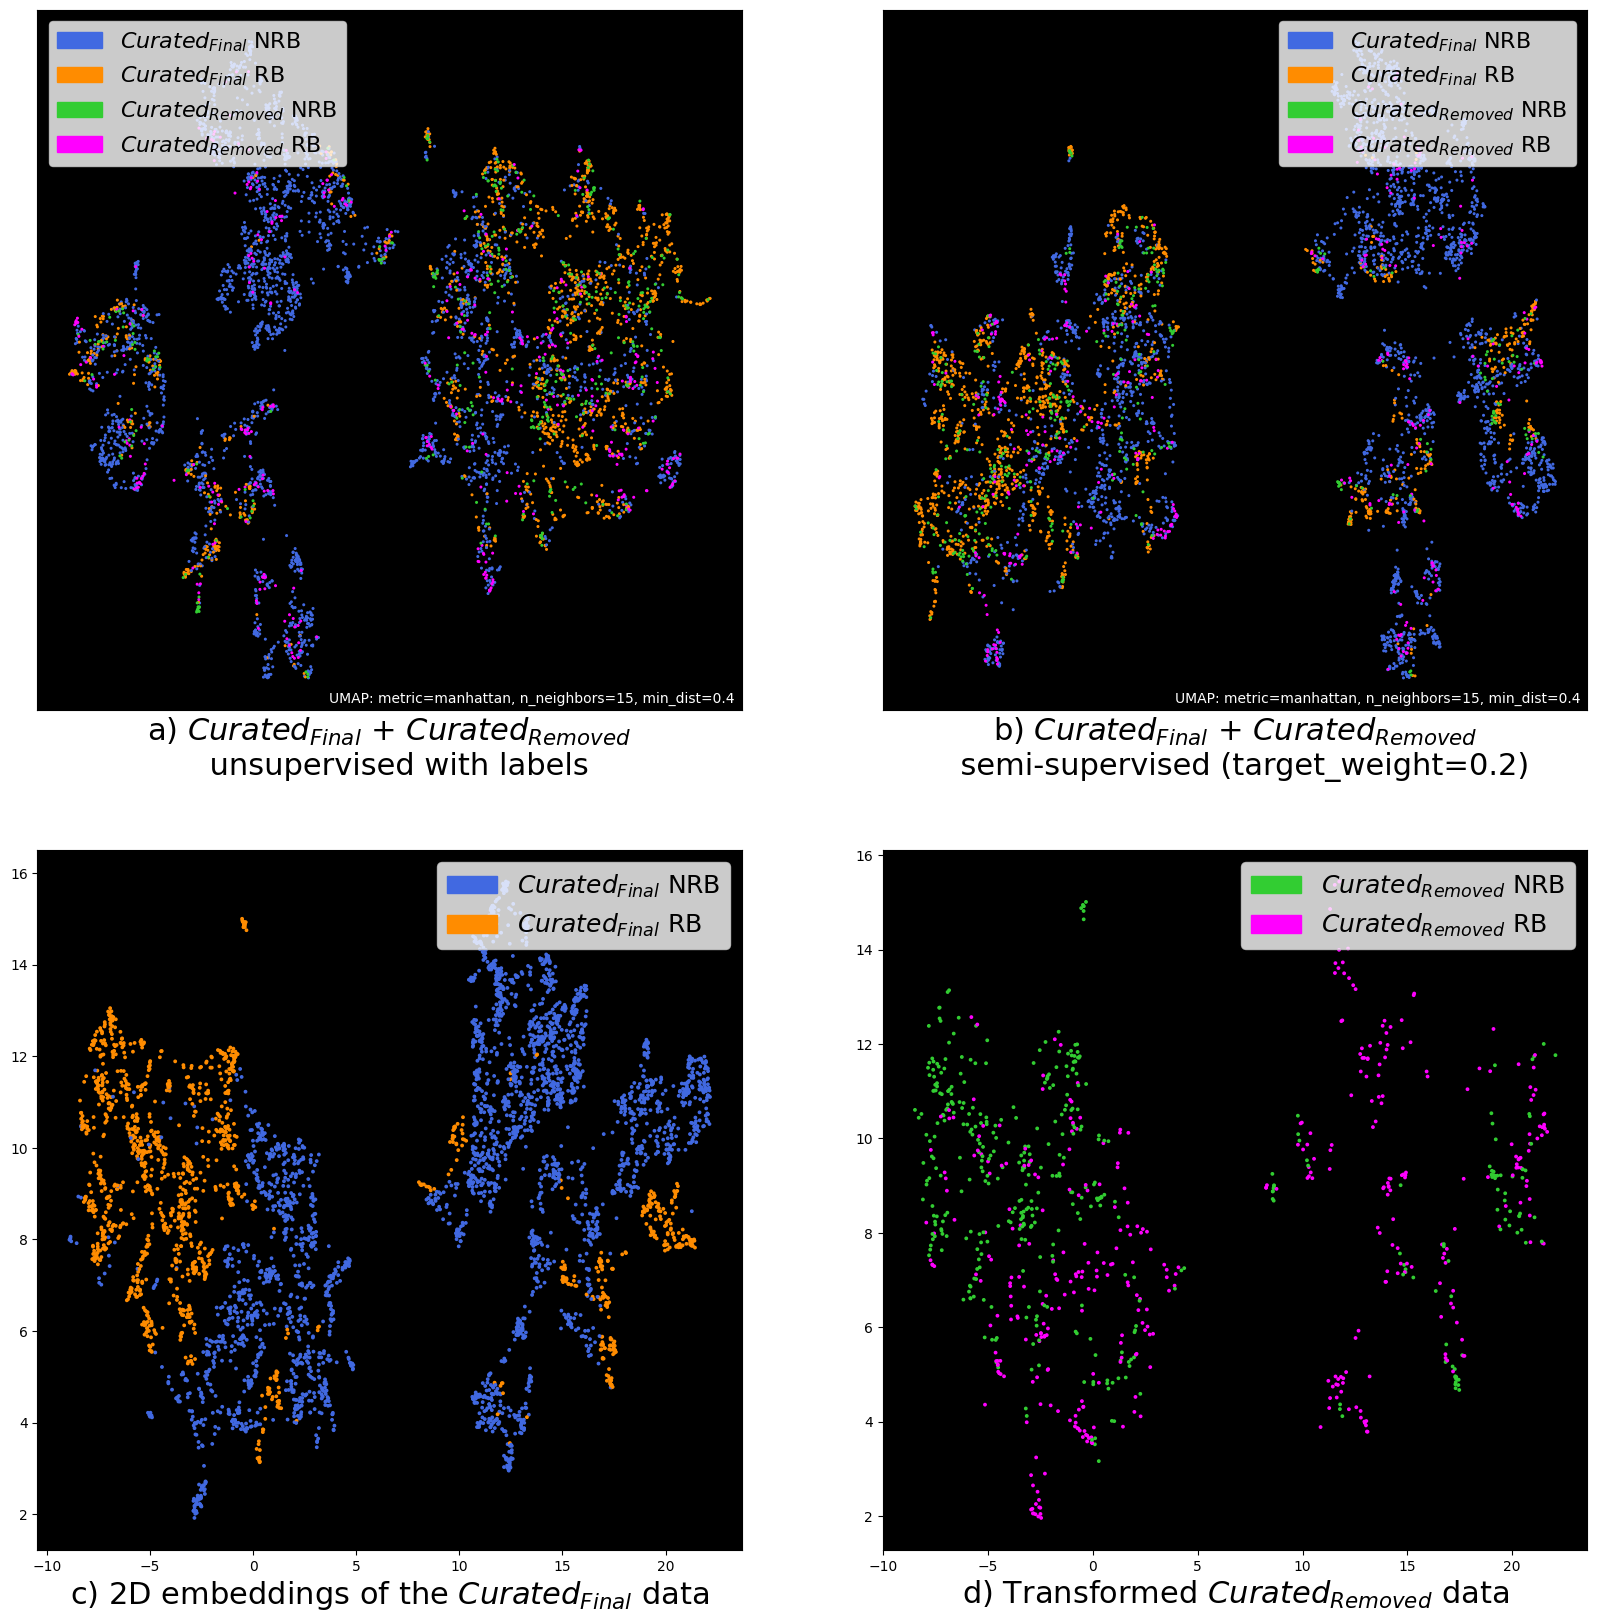

In [24]:
create_plot_umap_different_features(
    n_components=2, 
    n_neighbors=15, 
    min_dist=0.4, 
    target_weight=0.2, 
    metric="manhattan", 
    random_state=42,
    fp_type="pubchem"
)

5069
4259
808
[0. 1. 2. 3.]
[-1  0  1]


/Users/paulina_koerner/Desktop/MasterThesis/master_thesis_env/lib/python3.11/site-packages/scipy/sparse/_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


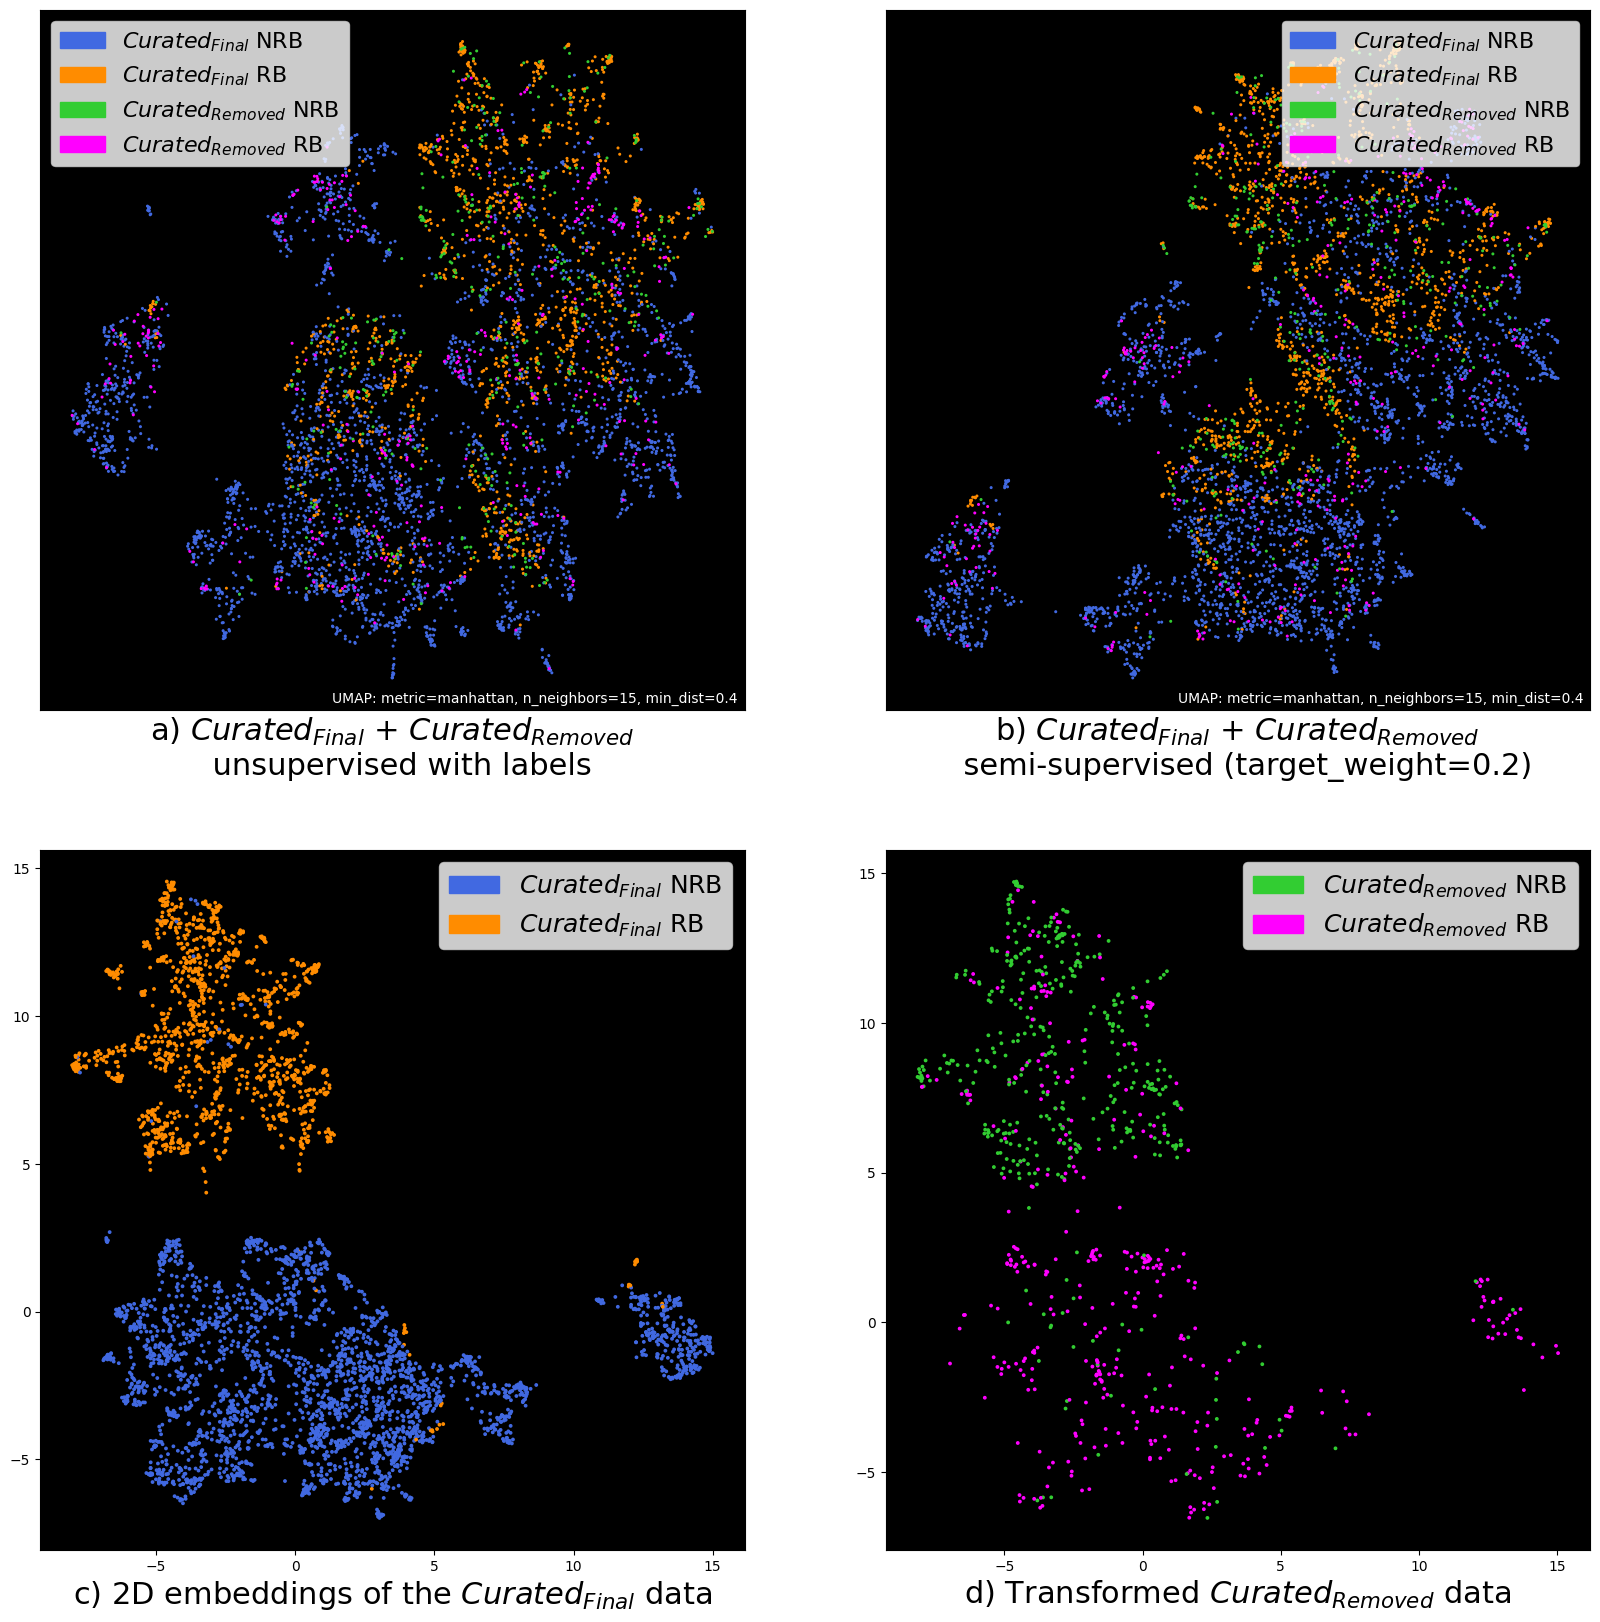

In [25]:
create_plot_umap_different_features(
    n_components=2, 
    n_neighbors=15, 
    min_dist=0.4, 
    target_weight=0.2, 
    metric="manhattan", 
    random_state=42,
    fp_type="maccs"
)

5069
4259
808
[0. 1. 2. 3.]
[-1  0  1]


/Users/paulina_koerner/Desktop/MasterThesis/master_thesis_env/lib/python3.11/site-packages/scipy/sparse/_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


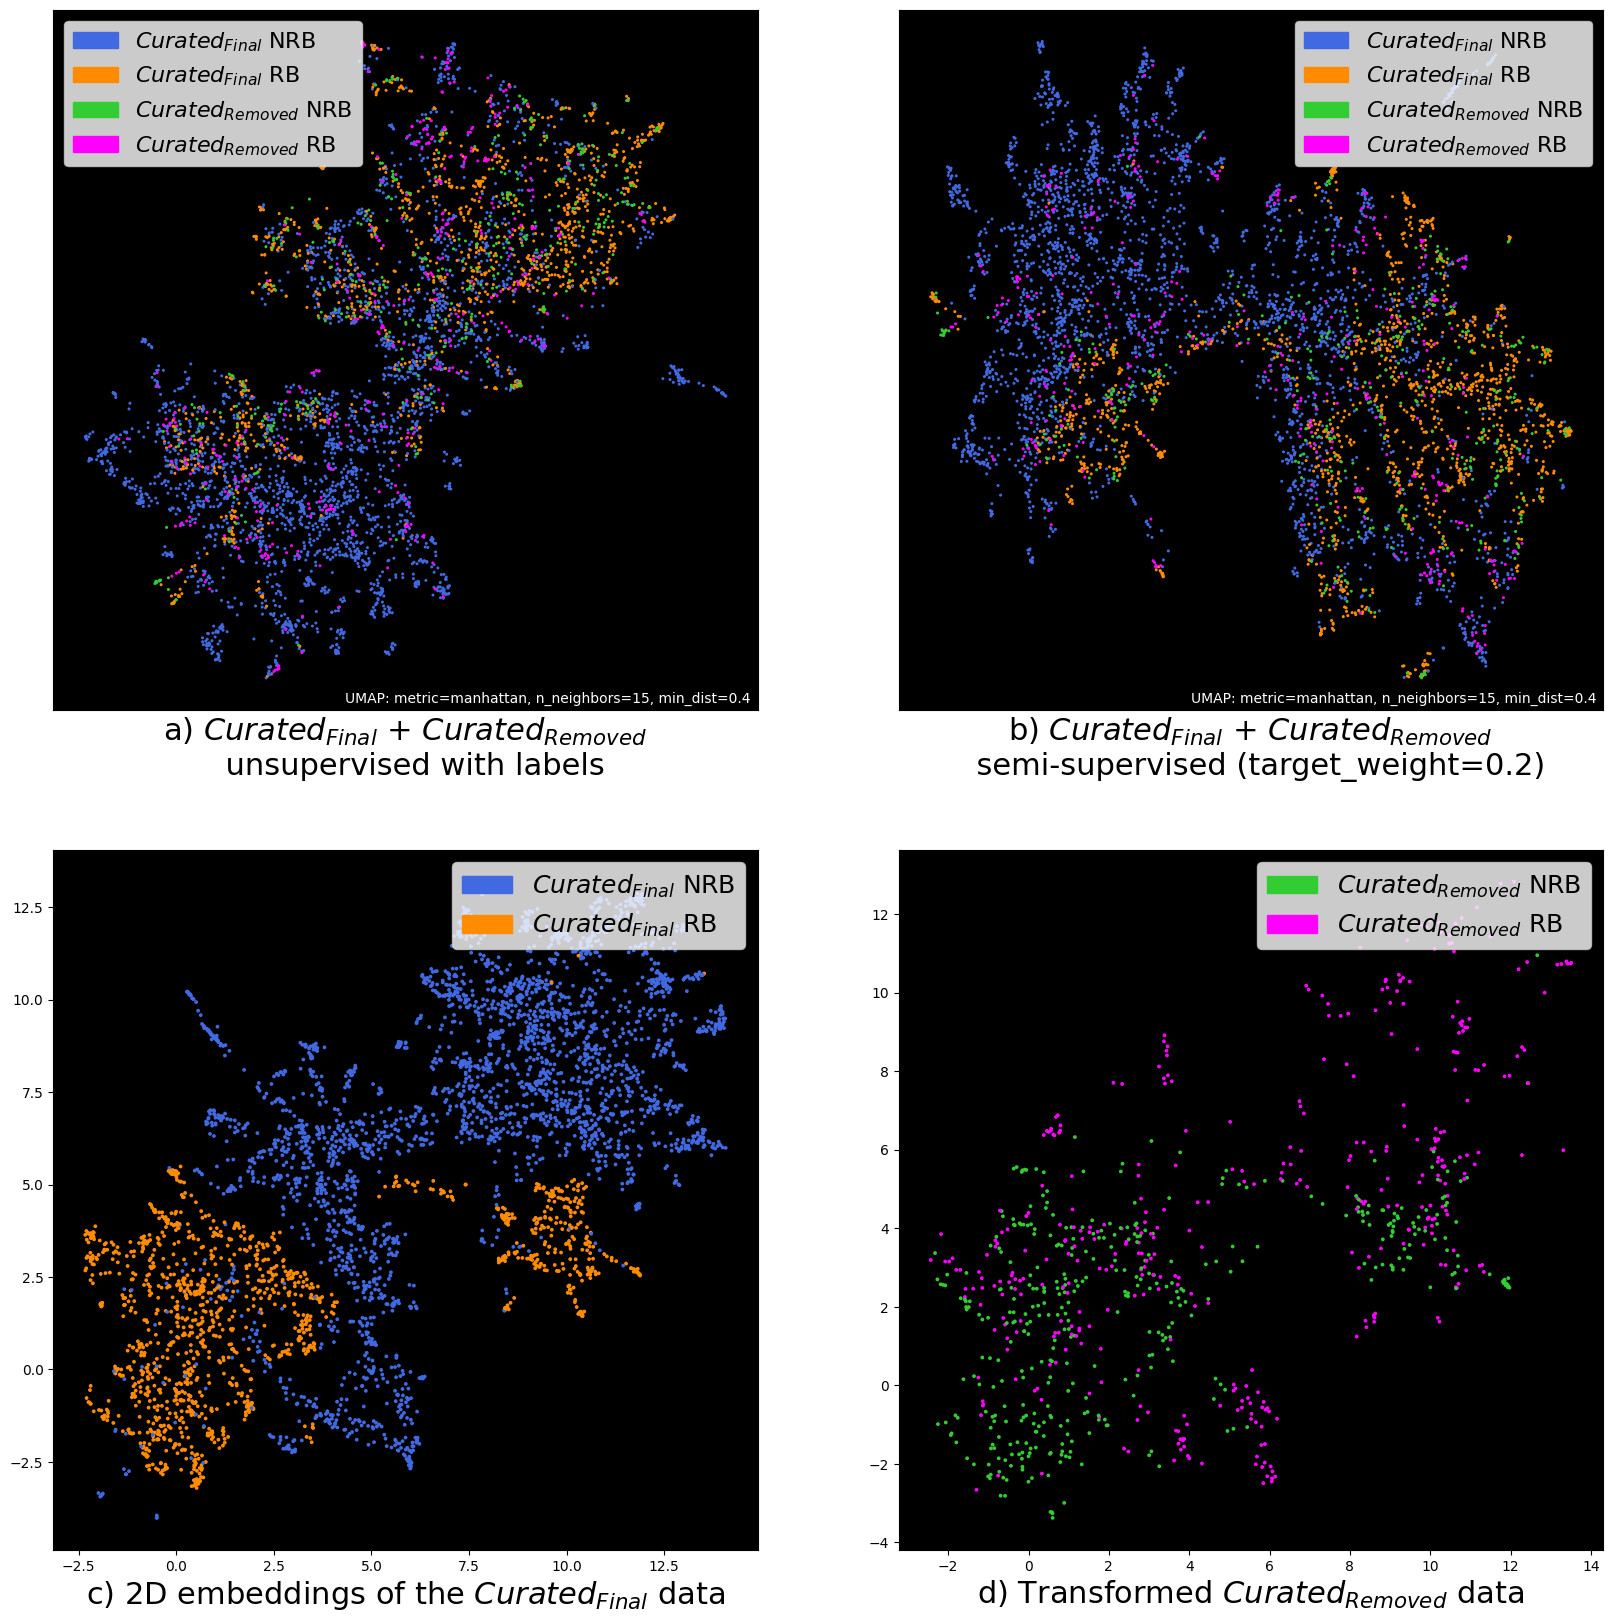

In [26]:
create_plot_umap_different_features(
    n_components=2, 
    n_neighbors=15, 
    min_dist=0.4, 
    target_weight=0.2, 
    metric="manhattan", 
    random_state=42,
    fp_type="rdk"
)

5069
4259
808
[0. 1. 2. 3.]
[-1  0  1]


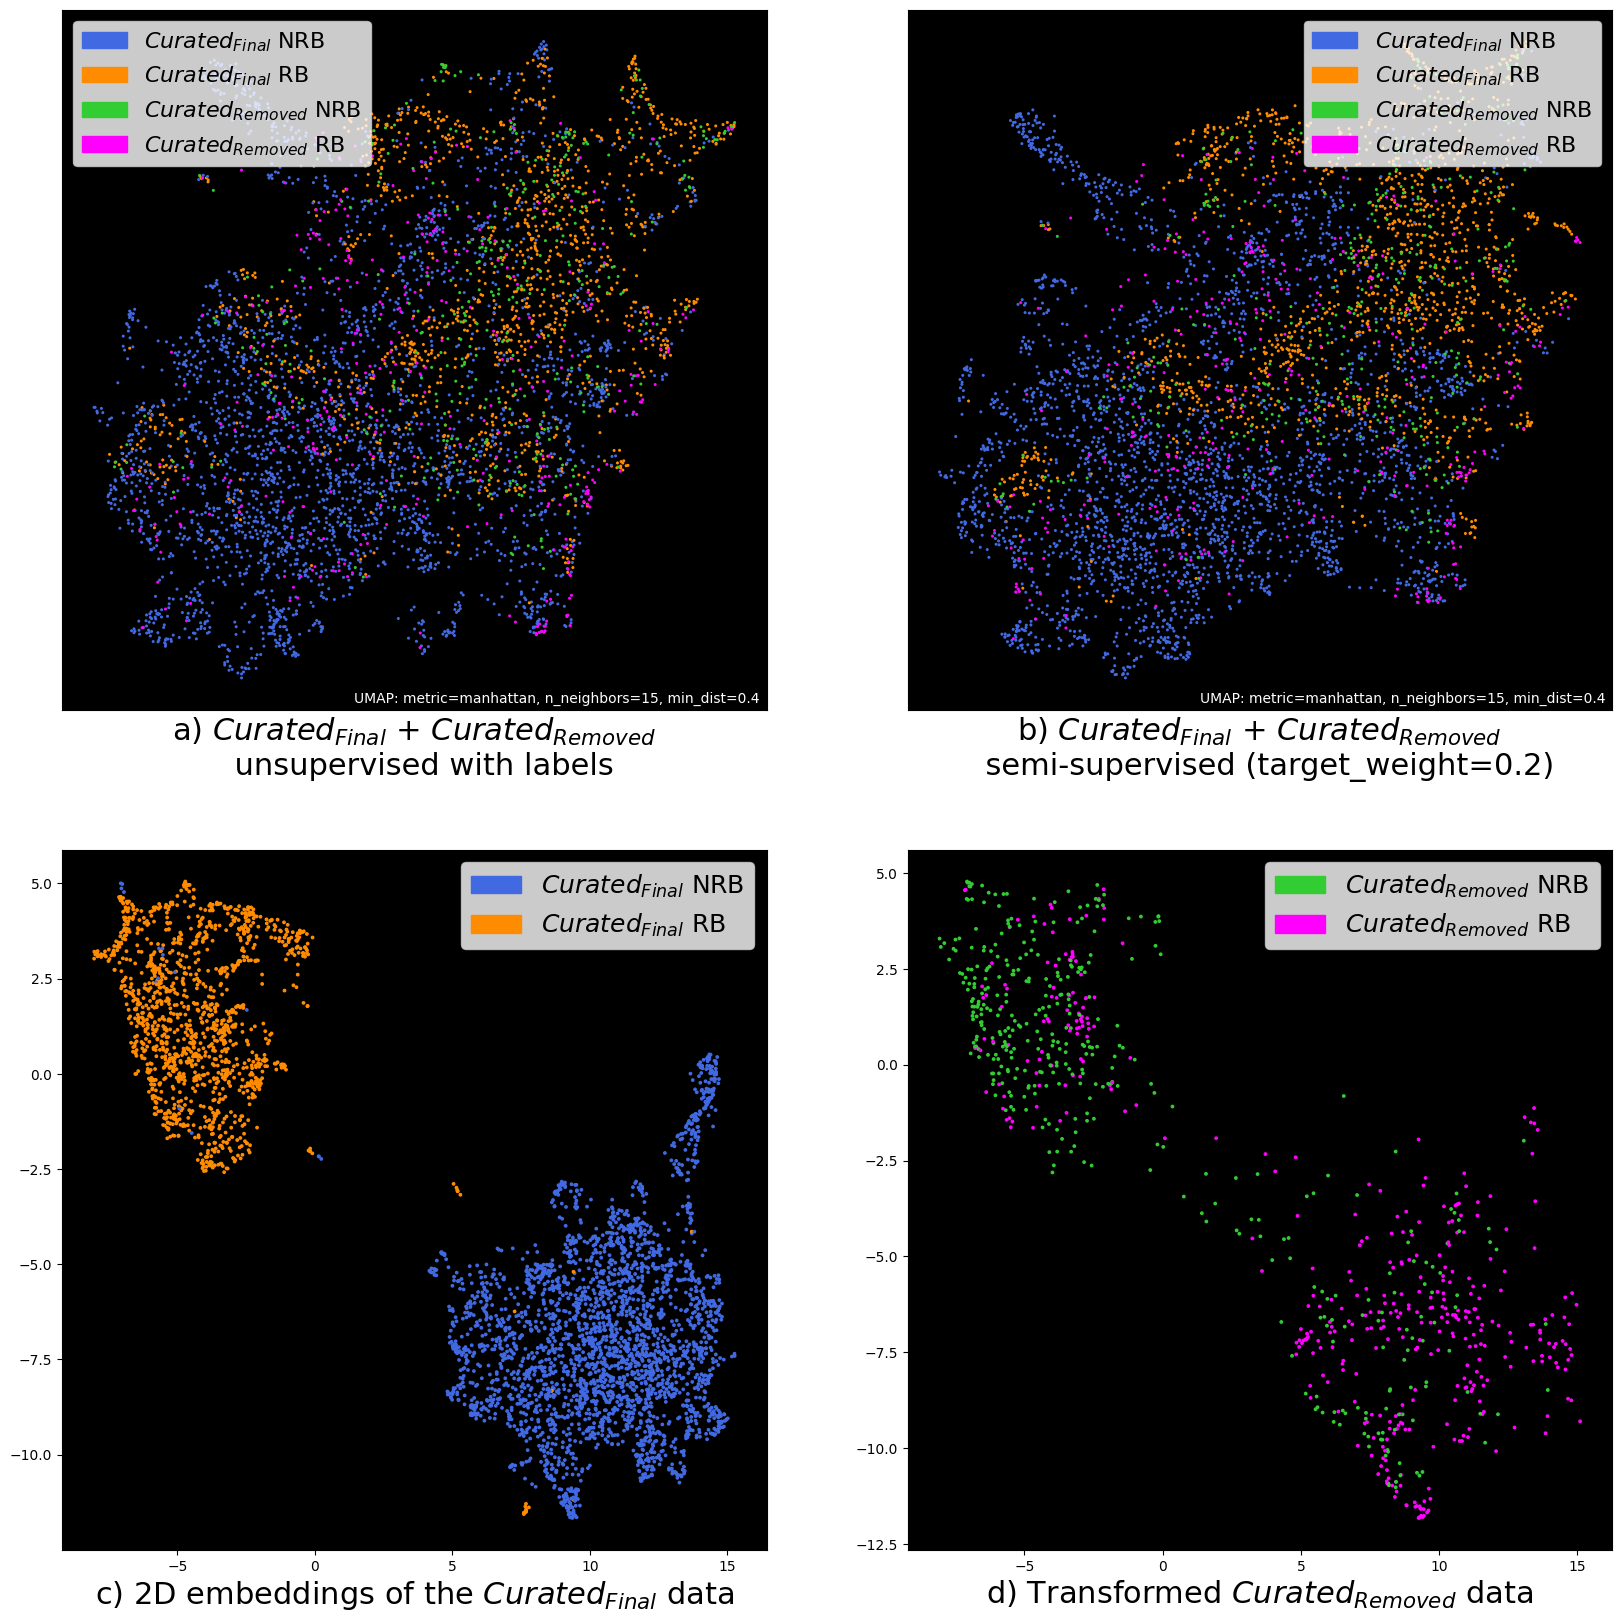

In [30]:
create_plot_umap_different_features(
    n_components=2, 
    n_neighbors=15, 
    min_dist=0.4, 
    target_weight=0.2, 
    metric="manhattan", 
    random_state=42,
    fp_type="molformer"
)

## Semi-supervised depending on weight

In [ ]:
def create_dfs_from_final_and_removed(df_final: pd.DataFrame, df_removed: pd.DataFrame, final: bool, fp_type: str) -> Tuple[
    pd.DataFrame, 
    pd.DataFrame, 
    pd.DataFrame, 
    pd.DataFrame, 
    pd.DataFrame, 
    pd.DataFrame, 
]:
    def convert_to_rdk_fingerprints(df: pd.DataFrame) -> pd.DataFrame:
        # calculate 2048 bit RDK fingerprint
        df = df.copy()
        mols = [AllChem.MolFromSmiles(smiles) for smiles in df["smiles"]]
        fp_vecs = [Chem.RDKFingerprint(mol) for mol in mols]
        fp_arrays = [np.frombuffer(fp_vec.ToBitString().encode(), 'u1') - ord('0') for fp_vec in fp_vecs]
        df["fingerprint"] = [fp_array.tolist() for fp_array in fp_arrays]
        return df

    def convert_to_maccs_fingerprints(df: pd.DataFrame) -> pd.DataFrame:
        df = df.copy()
        mols = [AllChem.MolFromSmiles(smiles) for smiles in df["smiles"]]
        fp_vecs = [GetMACCSKeysFingerprint(mol) for mol in mols]
        fp_arrays = [np.frombuffer(fp_vec.ToBitString().encode(), 'u1') - ord('0') for fp_vec in fp_vecs]
        df["fingerprint"] = [fp_array.tolist() for fp_array in fp_arrays]
        return df

    def convert_to_pubchem_fingerprints(df: pd.DataFrame) -> pd.DataFrame:
        # calculate 881 bit PubChem fingerprint
        def get_pubchem_fp_padel(row) -> np.ndarray:
            smiles = row["smiles"]
            try:
                fingerprint_dict = from_smiles(smiles, fingerprints=True, descriptors=False)
            except: 
                print("Error when retrieving PubChem FP for SMILES ", smiles)
                return None
            fp = [int(bit) for bit in fingerprint_dict.values()]
            return fp
        
        df["fingerprint"] = df.progress_apply(get_pubchem_fp_padel, axis=1).to_list()
        df = df[df["fingerprint"] != None]
        return df

    if fp_type=="rdk":
        size = 2048
        df_final = convert_to_rdk_fingerprints(df=df_final)
        df_removed = convert_to_rdk_fingerprints(df=df_removed)
    elif fp_type=="maccs":
        size = 167
        df_final = convert_to_maccs_fingerprints(df=df_final)
        df_removed = convert_to_maccs_fingerprints(df=df_removed)
    elif fp_type=="pubchem":
        size = 881
        new = False # TODO
        if new:
            df_final = convert_to_pubchem_fingerprints(df=df_final)
            df_final.to_csv("datasets/different_features/df_final_pubchem_fingerprints.csv")
            df_removed = convert_to_pubchem_fingerprints(df=df_removed)
            df_removed.to_csv("datasets/different_features/df_removed_pubchem_fingerprints.csv")
        else:
            df_final = pd.read_csv("datasets/different_features/df_final_pubchem_fingerprints.csv", index_col=0)
            df_final = df_final.dropna(subset=['fingerprint'], how='any', ignore_index=True)
            df_final['fingerprint'] = df_final['fingerprint'].apply(lambda x: [int(val) if val != 'nan' else np.nan for val in str(x).strip('[]').split()])

            df_removed = pd.read_csv("datasets/different_features/df_removed_pubchem_fingerprints.csv", index_col=0)
            df_removed = df_removed.dropna(subset=['fingerprint'], how='any', ignore_index=True)
            df_removed['fingerprint'] = df_removed['fingerprint'].apply(lambda x: [int(val) if val != 'nan' else np.nan for val in str(x).strip('[]').split()])


    elif fp_type=="molformer":
        size = 768
        df_final = pd.read_csv("datasets/different_features/df_final_molformer_embeddings.csv", index_col=0)
        df_final['fingerprint'] = df_final['fingerprint'].apply(eval)
        df_removed = pd.read_csv("datasets/different_features/df_removed_molformer_embeddings.csv", index_col=0)
        df_removed['fingerprint'] = df_removed['fingerprint'].apply(eval)
    
    if final: 
        curated = "$Curated_{Final}$"
        removed = "$Curated_{Removed}$"
    else: 
        curated = "$Curated_{BIOWIN}$"
        removed = "$Curated_{Problematic}$"

    cols = [*range(0, size, 1)] 
    df_final_fp = pd.DataFrame(df_final.fingerprint.tolist(), columns=cols)
    df_removed_fp = pd.DataFrame(df_removed.fingerprint.tolist(), columns=cols)
    # Create scs labeled with removed and kept
    df_final_fp["label"] = curated
    df_removed_fp["label"] = removed
    df_scs_removed_labels = pd.concat([df_final_fp, df_removed_fp], axis=0)
    df_scs_removed_labels.reset_index(inplace=True, drop=True)
    df_scs_removed_labels["label_str"] = df_scs_removed_labels['label']

    # Create scs labeled with two labels: RB and NRB
    df_final_fp["label"] = df_final["label"]
    df_removed_fp["label"] = df_removed['label']
    df_scs_two_labels = pd.concat([df_final_fp, df_removed_fp], axis=0)
    df_scs_two_labels.reset_index(inplace=True, drop=True)
    df_scs_two_labels["label_str"] = df_scs_two_labels['label'].map({0: f"{curated} NRB", 1: f"{curated} RB"})

    # Create scs labeled with four labels: RB and NRB
    df_final_fp["label"] = df_final["label"]
    df_removed_fp["label"] = df_removed['label'] + 2
    df_scs_four_labels = pd.concat([df_final_fp, df_removed_fp], axis=0)
    df_scs_four_labels.reset_index(inplace=True, drop=True)
    df_scs_four_labels["label_str"] = df_scs_four_labels['label'].map({0: f"{curated} NRB", 1: f"{curated} RB", 2: f"{removed} NRB", 3: f"{removed} RB"})

    # Create scs labeled with two labels four colors
    df_removed_fp["label"] = df_removed['label']
    df_scs_two_labels_four_colors = pd.concat([df_final_fp, df_removed_fp], axis=0)
    df_scs_two_labels_four_colors.reset_index(inplace=True, drop=True)
    df_scs_two_labels_four_colors["label_str"] = df_scs_four_labels['label_str']

    # Create final labeled with RB and NRB
    df_final_fp_labeled = pd.DataFrame(df_final.fingerprint.tolist(), columns=cols)
    df_final_fp_labeled["label"] = df_final["label"]
    df_final_fp_labeled["label_str"] = df_final_fp_labeled['label'].map({0: f"{curated} NRB", 1: f"{curated} RB"})

    # semisupervised
    df_removed_fp["label"] = -1 # TODO
    df_scs_semi_supervised = pd.concat([df_final_fp, df_removed_fp], axis=0)
    df_scs_semi_supervised.reset_index(inplace=True, drop=True)
    df_scs_semi_supervised["label_str"] = df_scs_four_labels['label_str']

    # final 
    df_final_data = df_final_fp.copy()
    df_final_data["label_str"] = df_final_data['label'].map({0: f"{curated} NRB", 1: f"{curated} RB"})

    # removed
    df_removed_data = df_removed_fp.copy()
    df_removed_data["label"] = df_removed["label"]
    df_removed_data["label_str"] = df_removed_data['label'].map({0: f"{removed} NRB", 1: f"{removed} RB"})

    return df_final_data, df_removed_data, df_scs_removed_labels, df_scs_two_labels, df_scs_four_labels, df_scs_two_labels_four_colors, df_final_fp_labeled, df_scs_semi_supervised



def create_plot(
    manifolds: List[umap.umap_.UMAP], 
    y_strs: List[np.ndarray], 
    titles: List[str], 
    legend_loc: List[str], 
    number_of_labels: List[int],
) -> None:

    fig, axs = plt.subplots(2, 2, figsize=(20, 20)) #(Suplots: rows, cols -> 3, 2), figsize = (20,30)

    for i, ax in enumerate(axs.flatten()):
        label=y_strs[i]

        curated = "$Curated_{Final}$"
        removed = "$Curated_{Removed}$"

        if ('NRB' in label[0]) | ('RB' in label[0]):
            color_key={
                f"{curated} NRB": 'royalblue', 
                f"{removed} NRB": 'limegreen', 
                f"{curated} RB": 'darkorange', 
                f"{removed} RB": 'fuchsia'} 
        else: 
            color_key={
                curated: 'green', 
                removed: 'gold'}

        umap.plot.points(
            umap_object=manifolds[i], 
            labels=label, 
            color_key=color_key,
            background='black',
            ax=ax,
        ) 
        ax.set_xlabel(titles[i], fontsize=22)
        nrb = mpatches.Patch(color='royalblue', label=f"{curated} NRB")
        rb = mpatches.Patch(color='darkorange', label=f"{curated} RB")
        if number_of_labels[i] == 4:
            nrb_r = mpatches.Patch(color='limegreen', label=f"{removed} NRB")
            rb_r = mpatches.Patch(color='fuchsia', label=f"{removed} RB")
            ax.legend(loc=legend_loc[i], handles=[nrb, rb, nrb_r, rb_r], fontsize=16)
        elif ('NRB' not in label[0]) & ('RB' not in label[0]):
            cb = mpatches.Patch(color='green', label=curated)
            cr = mpatches.Patch(color='gold', label=removed)
            ax.legend(loc=legend_loc[i], handles=[cb, cr], fontsize=16)
        else:
            ax.legend(loc=legend_loc[i], handles=[nrb, rb], fontsize=16)

def create_plot_umap_test_semi_supervised(
    n_components, 
    n_neighbors, 
    min_dist, 
    metric, 
    random_state,
    fp_type,
) -> None:

    # Final
    _, _, _, _, _, _, _, df_scs_semi_supervised_final = create_dfs_for_umap_different_features(fp_type)


    manifold_semi_supervised1, y_str_semi_supervised1 = create_manifold(
        df=df_scs_semi_supervised_final, 
        n_components=n_components,
        n_neighbors=n_neighbors, 
        min_dist=min_dist,
        metric=metric,
        random_state=random_state,
        target_weight=0.1,
        supervised=True,
    )
    manifold_semi_supervised2, y_str_semi_supervised2 = create_manifold(
        df=df_scs_semi_supervised_final, 
        n_components=n_components,
        n_neighbors=n_neighbors, 
        min_dist=min_dist,
        metric=metric,
        random_state=random_state,
        target_weight=0.2,
        supervised=True,
    )
    manifold_semi_supervised4, y_str_semi_supervised4 = create_manifold(
        df=df_scs_semi_supervised_final, 
        n_components=n_components,
        n_neighbors=n_neighbors, 
        min_dist=min_dist,
        metric=metric,
        random_state=random_state,
        target_weight=0.4,
        supervised=True,
    )
    manifold_semi_supervised6, y_str_semi_supervised6 = create_manifold(
        df=df_scs_semi_supervised_final, 
        n_components=n_components,
        n_neighbors=n_neighbors, 
        min_dist=min_dist,
        metric=metric,
        random_state=random_state,
        target_weight=0.6,
        supervised=True,
    )


    # Create plot
    manifolds = [
        manifold_semi_supervised1, 
        manifold_semi_supervised2,
        manifold_semi_supervised4,
        manifold_semi_supervised6,
    ]
    y_strs = [
        y_str_semi_supervised1,
        y_str_semi_supervised2,
        y_str_semi_supervised4,
        y_str_semi_supervised6,
    ]

    titles = [
        'a) $Curated_{Final}$ + $Curated_{Removed}$ \n  semi-supervised (target_weight=0.1)',
        'b) $Curated_{Final}$ + $Curated_{Removed}$ \n  semi-supervised (target_weight=0.2)',
        'c) $Curated_{Final}$ + $Curated_{Removed}$ \n  semi-supervised (target_weight=0.4)',
        'd) $Curated_{Final}$ + $Curated_{Removed}$ \n  semi-supervised (target_weight=0.6)',
    ]
    legend_loc = [
        'upper right',
        'upper right',
        'upper left',
        'upper left',
    ]
    number_of_labels = [4, 4, 4, 4]

    create_plot(
        manifolds=manifolds, 
        y_strs=y_strs, 
        titles=titles, 
        legend_loc=legend_loc, 
        number_of_labels=number_of_labels,
    )


[-1  0  1]
[-1  0  1]
[-1  0  1]
[-1  0  1]


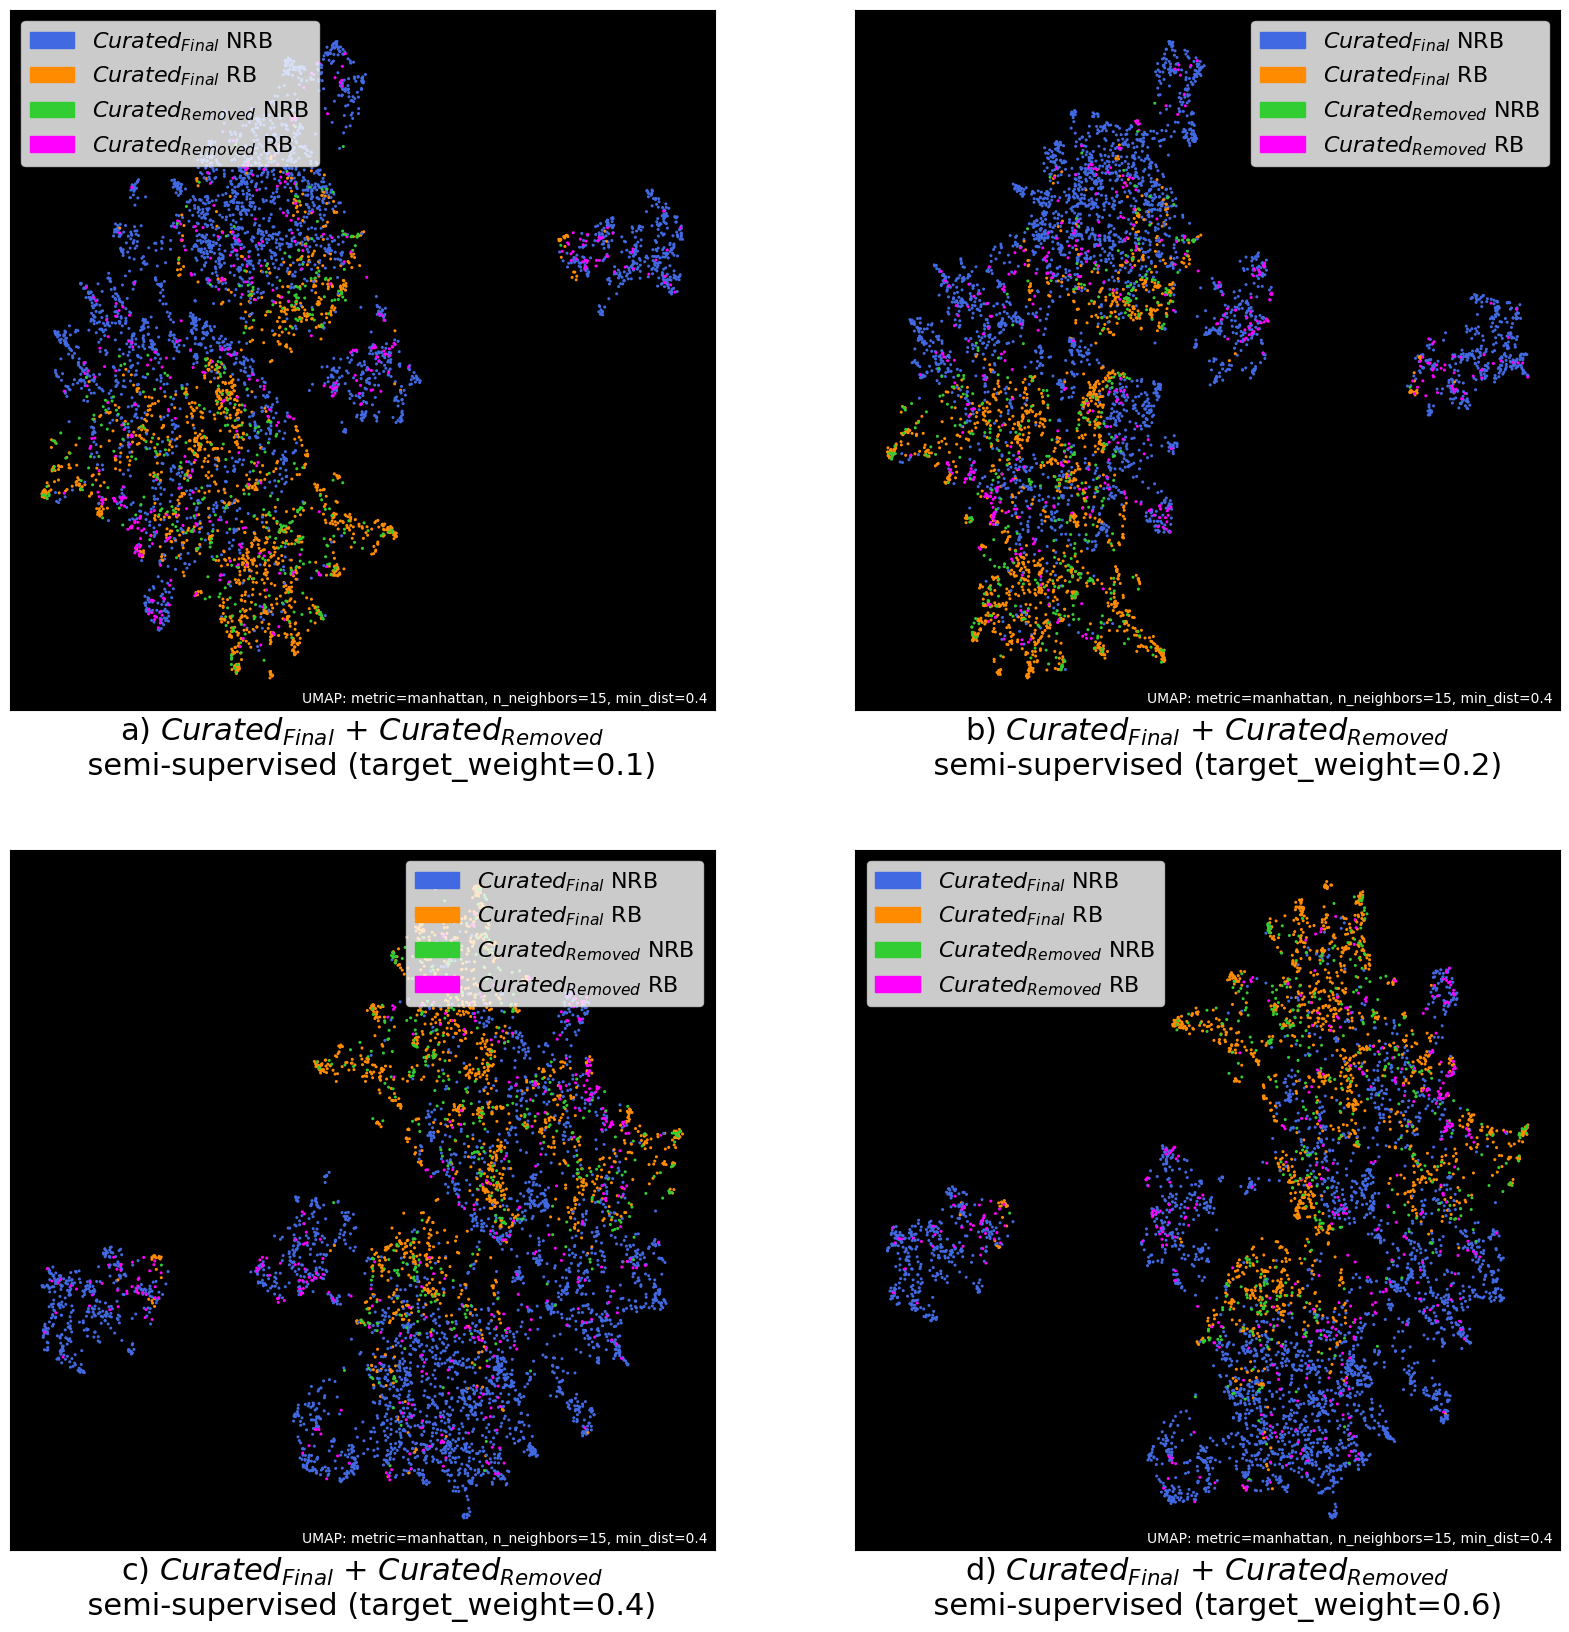

In [ ]:
create_plot_umap_test_semi_supervised(
    n_components=2, 
    n_neighbors=15, 
    min_dist=0.4, 
    metric="manhattan", 
    random_state=42,
    fp_type="maccs"
)

## Fit transform based on weight

In [59]:
def create_plot(
    manifolds: List[umap.umap_.UMAP], 
    y_strs: List[np.ndarray], 
    titles: List[str], 
    legend_loc: List[str], 
) -> None:

    fig, axs = plt.subplots(2, 2, figsize=(20, 20)) #(Suplots: rows, cols -> 3, 2), figsize = (20,30)

    for i, ax in enumerate(axs.flatten()):
        label=y_strs[i]

        curated = "$Curated_{Final}$"
        removed = "$Curated_{Removed}$"


        for indx in range(len(label)):
            if label[indx] == f"{curated} NRB":
                label[indx] = 'royalblue'
            elif label[indx] == f"{curated} RB":
                label[indx] = 'darkorange'
            elif label[indx] == f"{removed} NRB":
                label[indx] = 'limegreen'
            elif label[indx] == f"{removed} RB":
                label[indx] = 'fuchsia'
        
        manifolds_embedding = manifolds[i]
        ax.scatter(manifolds_embedding[:, 0], manifolds_embedding[:, 1], s=3, c=label)
        ax.set_xlabel(titles[i], fontsize=22)
        ax.set_facecolor('black')
        if '$Curated_{Final}$' in titles[i]:
            nrb = mpatches.Patch(color='royalblue', label=f"{curated} NRB")
            rb = mpatches.Patch(color='darkorange', label=f"{curated} RB")
            ax.legend(loc=legend_loc[i], handles=[nrb, rb], fontsize=18) #, title="Classes"
        else: 
            nrbr = mpatches.Patch(color='limegreen', label=f"{removed} NRB")
            rbr = mpatches.Patch(color='fuchsia', label=f"{removed} RB")
            ax.legend(loc=legend_loc[i], handles=[nrbr, rbr], fontsize=18) #, title="Classes"



def create_plot_umap_test_fit_transform(
    n_components, 
    n_neighbors, 
    min_dist, 
    metric, 
    random_state,
    fp_type,
) -> None:

    # Final
    df_final, df_removed, _, _, _, _, _, _ = create_dfs_for_umap_different_features(fp_type)

    # Fit final and then transform removed data
    x_final, y_final, y_final_str = df_final.drop(["label", "label_str"], axis=1), df_final[["label"]].values.flatten(), df_final[["label_str"]].values.flatten()
    
    manifold_final2 = umap.UMAP(
        n_components=n_components, 
        n_neighbors=n_neighbors, 
        min_dist=min_dist, 
        metric=metric, 
        random_state=random_state, 
        n_jobs=1,
        target_weight=0.2,
    ).fit(x_final, y_final)
    # Transform removed 
    x_removed2, _, y_removed_str2 = df_removed.drop(["label", "label_str"], axis=1), df_removed[["label"]].values.flatten(), df_removed[["label_str"]].values.flatten()
    manifold_fit_transform2 = manifold_final2.transform(x_removed2)

    manifold_final5 = umap.UMAP(
        n_components=n_components, 
        n_neighbors=n_neighbors, 
        min_dist=min_dist, 
        metric=metric, 
        random_state=random_state, 
        n_jobs=1,
        target_weight=0.5,
    ).fit(x_final, y_final)
    # Transform removed 
    x_removed5, _, y_removed_str5 = df_removed.drop(["label", "label_str"], axis=1), df_removed[["label"]].values.flatten(), df_removed[["label_str"]].values.flatten()
    manifold_fit_transform5 = manifold_final5.transform(x_removed5)


    # Create plot
    manifolds = [
        manifold_final2.embedding_,
        manifold_fit_transform2,
        manifold_final5.embedding_,
        manifold_fit_transform5,
    ]
    y_strs = [
        y_final_str,
        y_removed_str2,
        y_final_str,
        y_removed_str5,
    ]

    titles = [
        'a) 2D embeddings of the $Curated_{Final}$ data \n (target_weight=0.2)',
        'b) Transformed $Removed$ data \n (target_weight=0.2)',
        'c) 2D embeddings of the $Curated_{Final}$ data \n (target_weight=0.5)',
        'd) Transformed $Removed$ data \n (target_weight=0.5)',
    ]
    legend_loc = [
        'upper left',
        'upper left',
        'lower left',
        'lower left',
    ]

    create_plot(
        manifolds=manifolds, 
        y_strs=y_strs, 
        titles=titles, 
        legend_loc=legend_loc, 
    )


/Users/paulina_koerner/Desktop/MasterThesis/master_thesis_env/lib/python3.11/site-packages/scipy/sparse/_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)
/Users/paulina_koerner/Desktop/MasterThesis/master_thesis_env/lib/python3.11/site-packages/scipy/sparse/_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


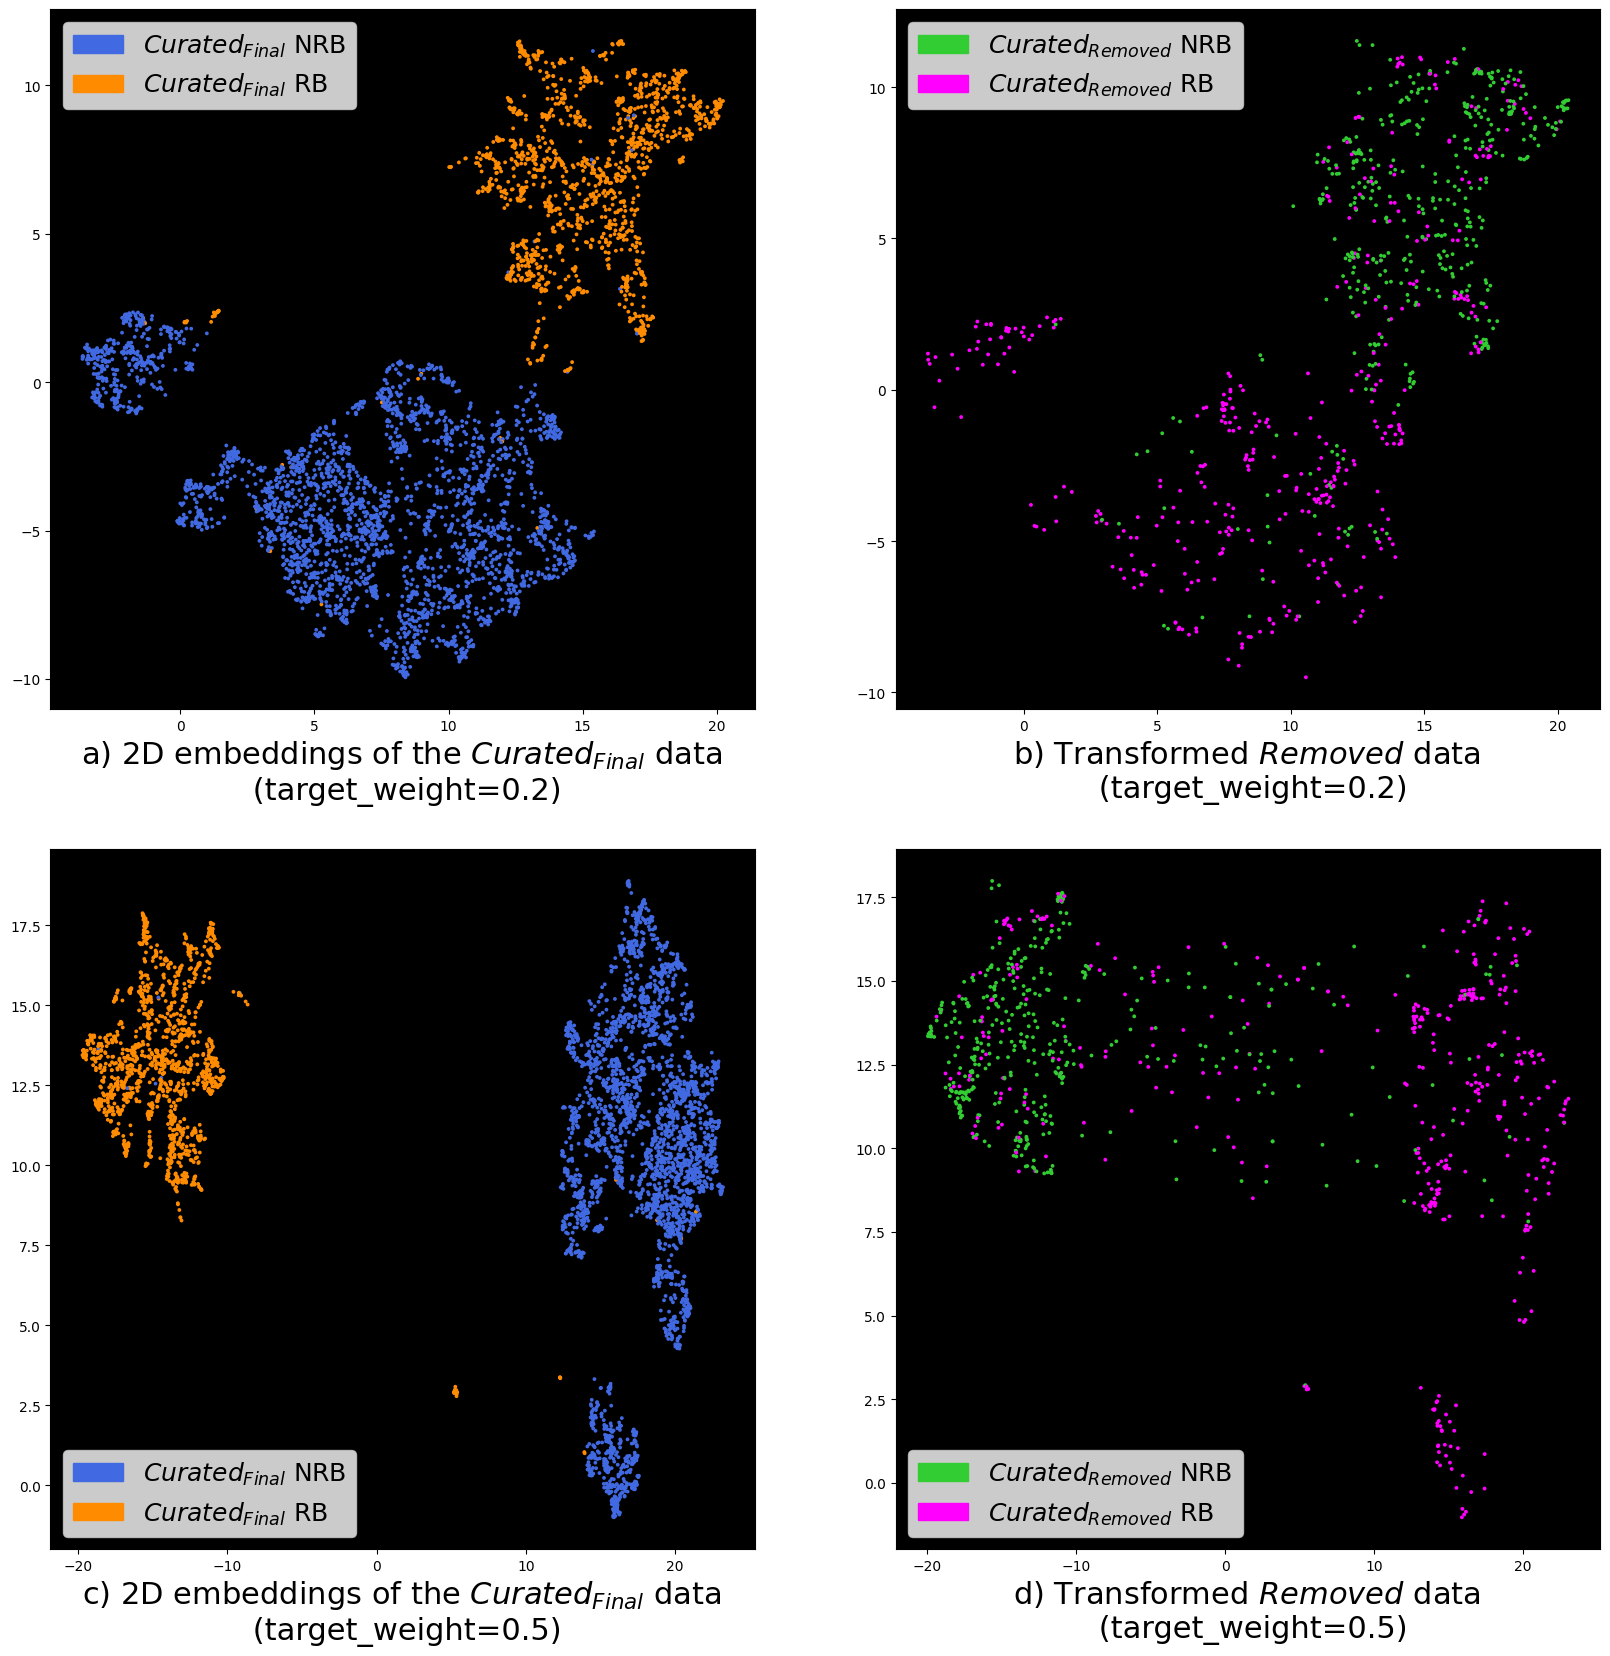

In [60]:
create_plot_umap_test_fit_transform(
    n_components=2, 
    n_neighbors=15, 
    min_dist=0.4, 
    metric="manhattan", 
    random_state=42,
    fp_type="maccs"
)